In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import get_iteration, last_tune_log, tune
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from torchtune.training.metric_logging import WandBLogger
from transformers import AutoTokenizer
import wandb

run_name = "010"
wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(436, 72, 92, 436)

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-19 18:00:00 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 18:00:01 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 18:00:01 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=N

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.22s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.11s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.12s/it]



INFO 02-19 18:00:14 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 18:00:15 worker.py:267] Memory profiling takes 0.93 seconds
INFO 02-19 18:00:15 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 18:00:15 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 18:00:15 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 18:00:15 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 18:00:55 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.51 seconds
INFO 02-19 18:00:56 api_server.py:756] Using supplied chat template:
INFO 02-19 18:00:56 api_server.py:756] None
INFO 02-19 18:00:56 launcher.py:21] Available routes are:
INFO 02-19 18:00:56 launcher.py:29] Route: /

INFO:     Started server process [29372]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 18:00:56 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39832 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

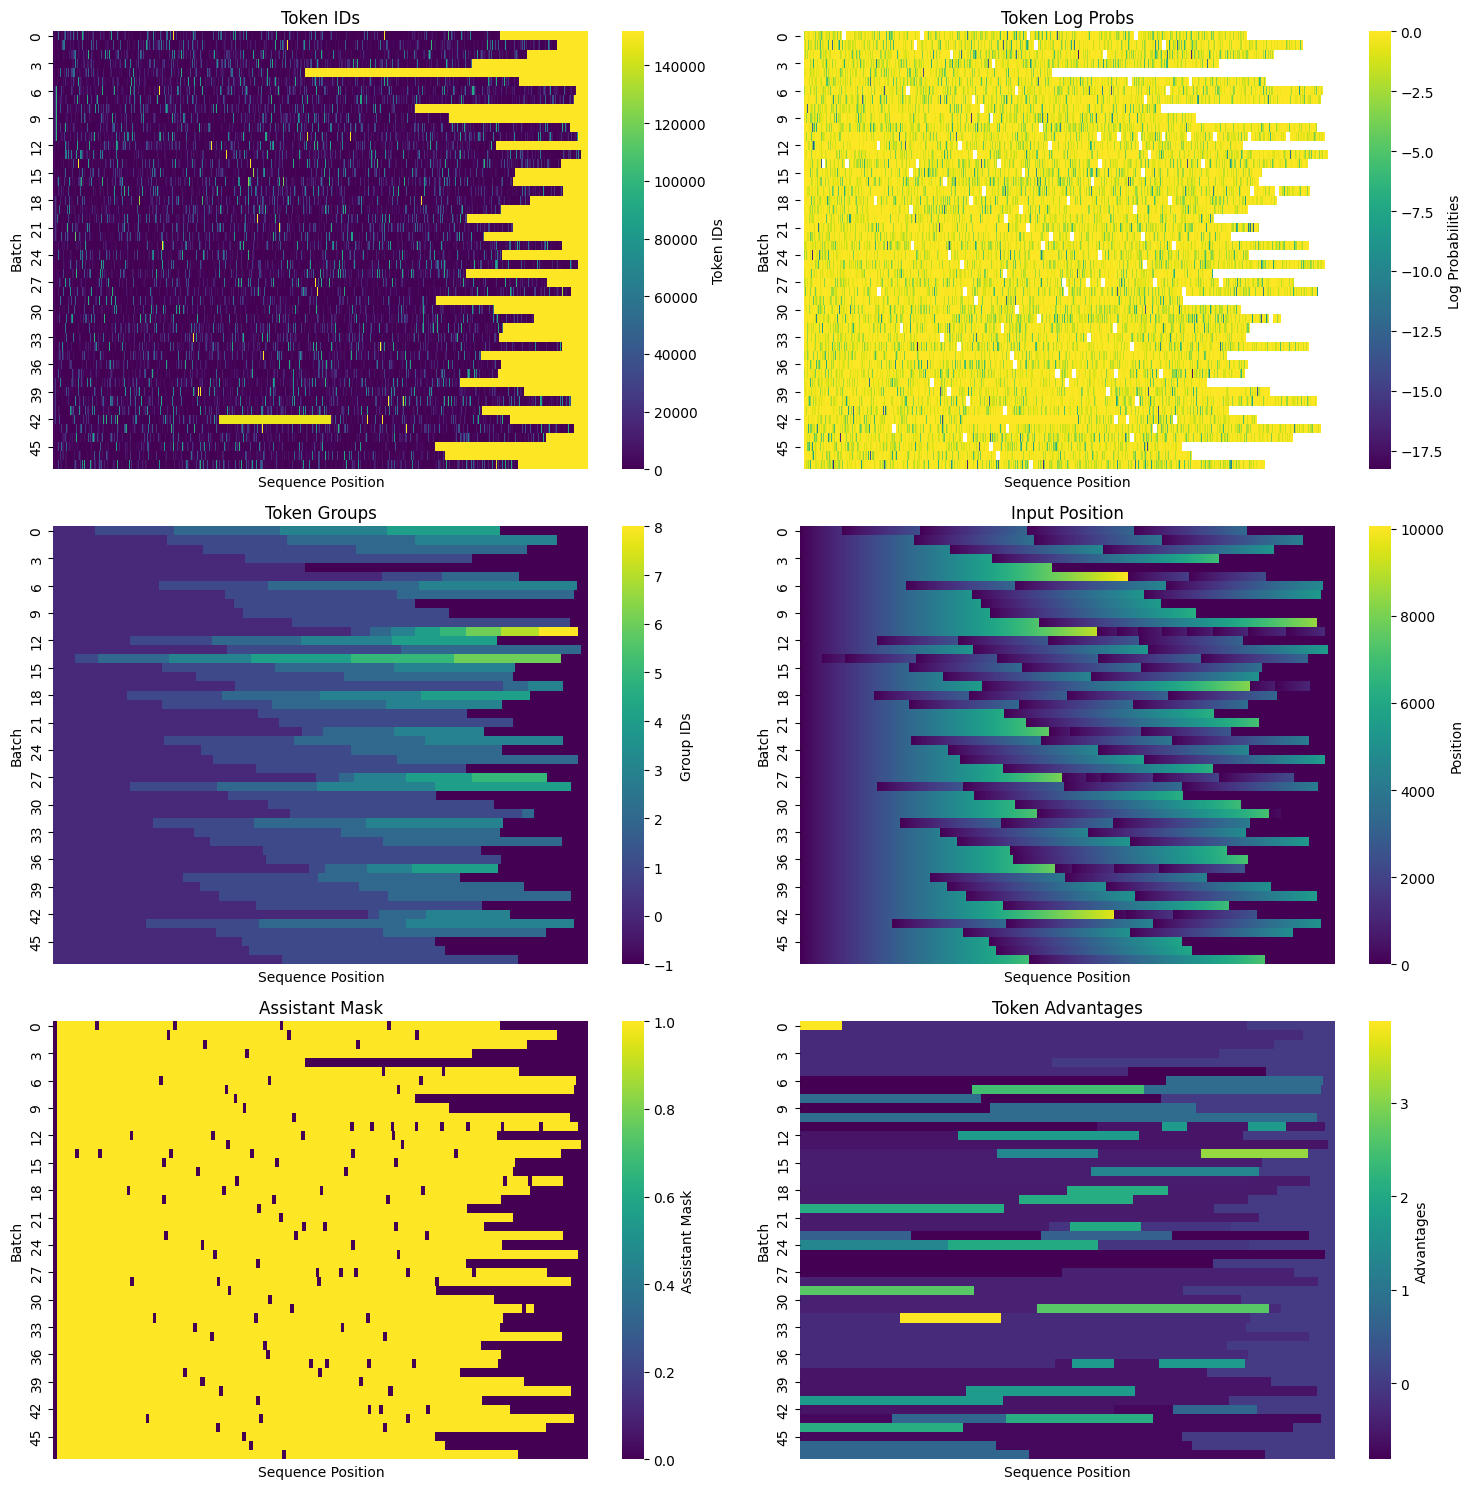

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739988601.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.34 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|24|Loss: 0.0846: 100%|██████████| 24/24 [09:28<00:00, 23.21s/it, entropy=2.42, kl_div=0.543, loss=0.0846, policy=0.0846]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.15 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 18:20:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 18:20:35 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 18:20:35 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.41s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.67s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.78s/it]



INFO 02-19 18:20:55 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 18:20:56 worker.py:267] Memory profiling takes 0.83 seconds
INFO 02-19 18:20:56 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 18:20:56 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 18:20:56 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 18:20:56 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 18:21:35 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.44 seconds
INFO 02-19 18:21:37 api_server.py:756] Using supplied chat template:
INFO 02-19 18:21:37 api_server.py:756] None
INFO 02-19 18:21:37 launcher.py:21] Available routes are:
INFO 02-19 18:21:37 launcher.py:29] Route: /

INFO:     Started server process [31009]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 18:21:39 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:50488 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

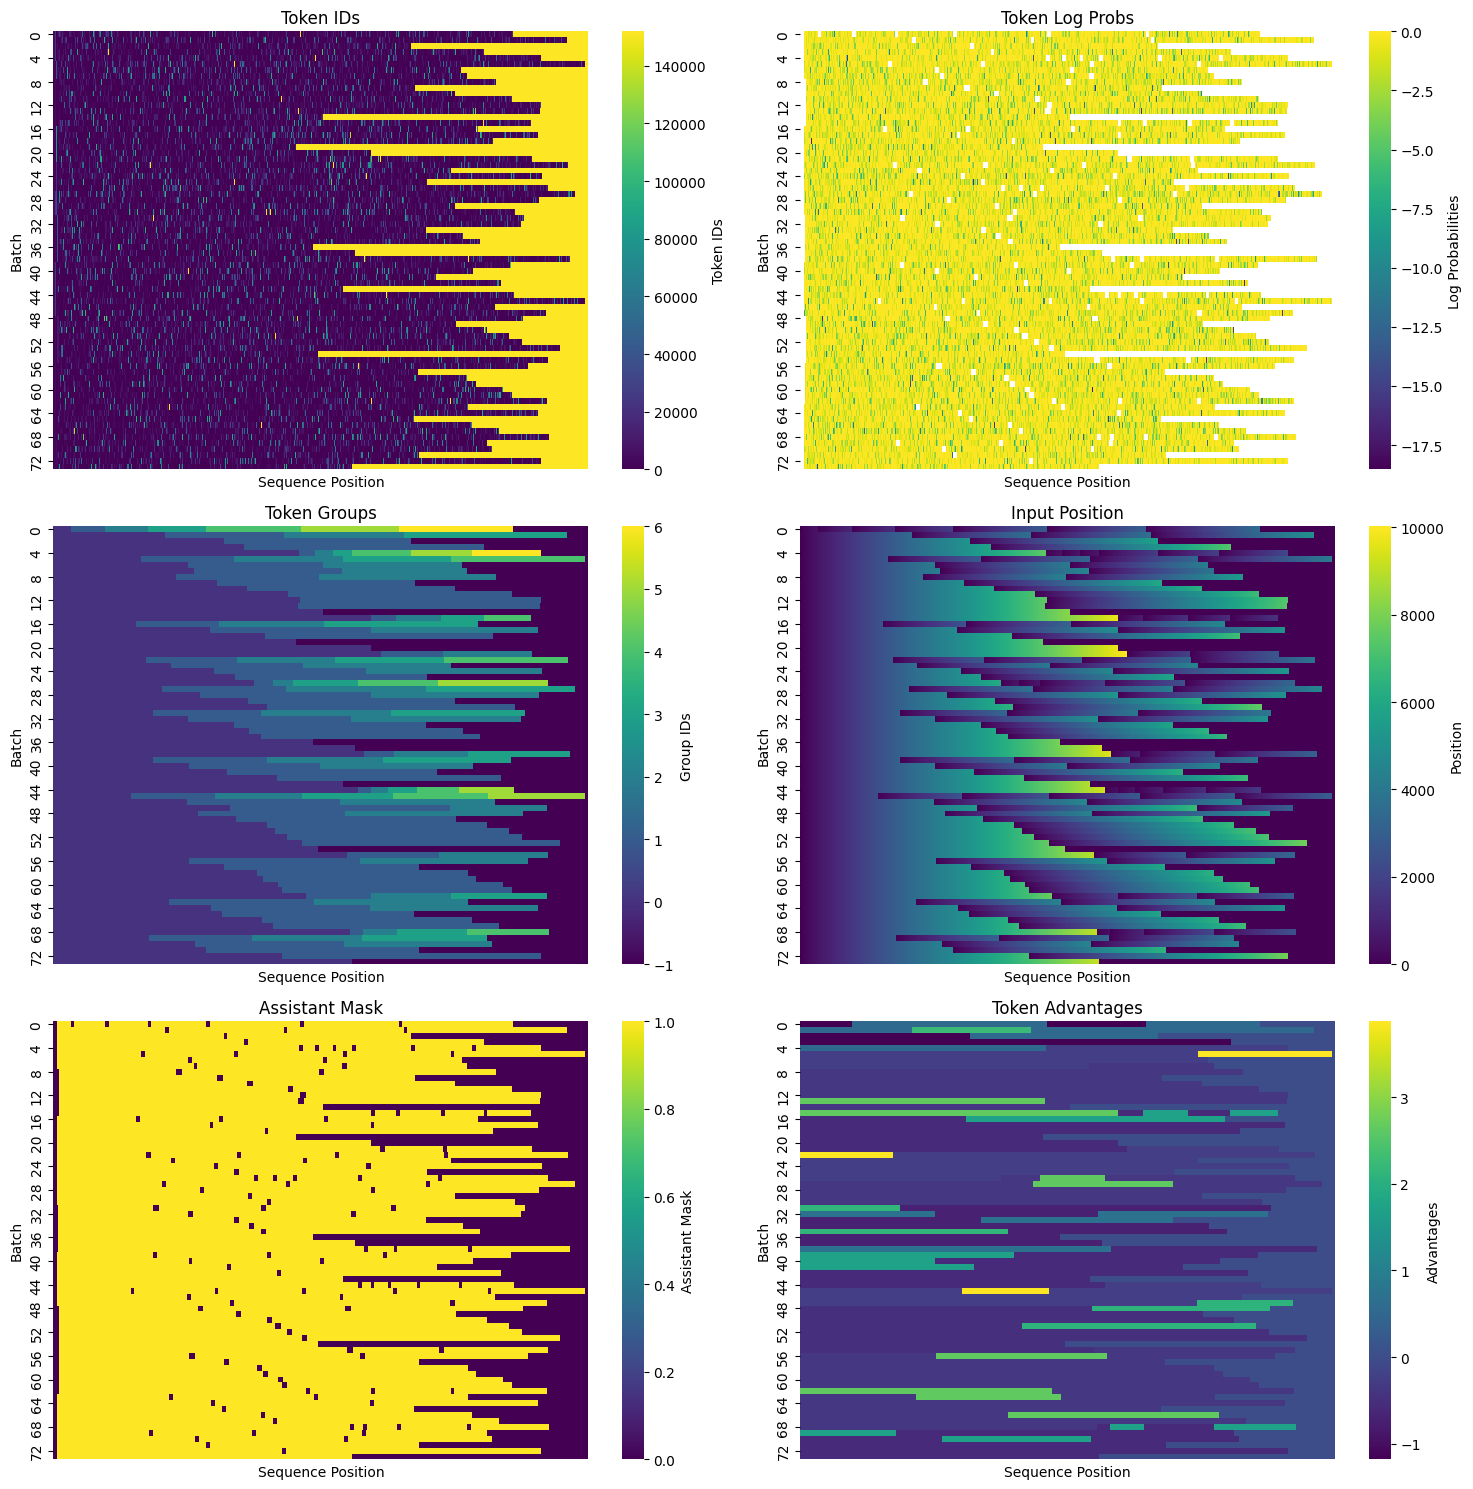

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739989868.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.60 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|37|Loss: 0.5670: 100%|██████████| 37/37 [14:30<00:00, 23.28s/it, entropy=2.4, kl_div=0.415, loss=0.567, policy=0.567]        INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.12 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB sa

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 18:46:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 18:46:45 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 18:46:45 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.46s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.70s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-19 18:47:04 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 18:47:05 worker.py:267] Memory profiling takes 0.84 seconds
INFO 02-19 18:47:05 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 18:47:05 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 18:47:05 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 18:47:05 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 18:47:45 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.31 seconds
INFO 02-19 18:47:46 api_server.py:756] Using supplied chat template:
INFO 02-19 18:47:46 api_server.py:756] None
INFO 02-19 18:47:46 launcher.py:21] Available routes are:
INFO 02-19 18:47:46 launcher.py:29] Route: /

INFO:     Started server process [33251]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 18:47:46 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39568 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

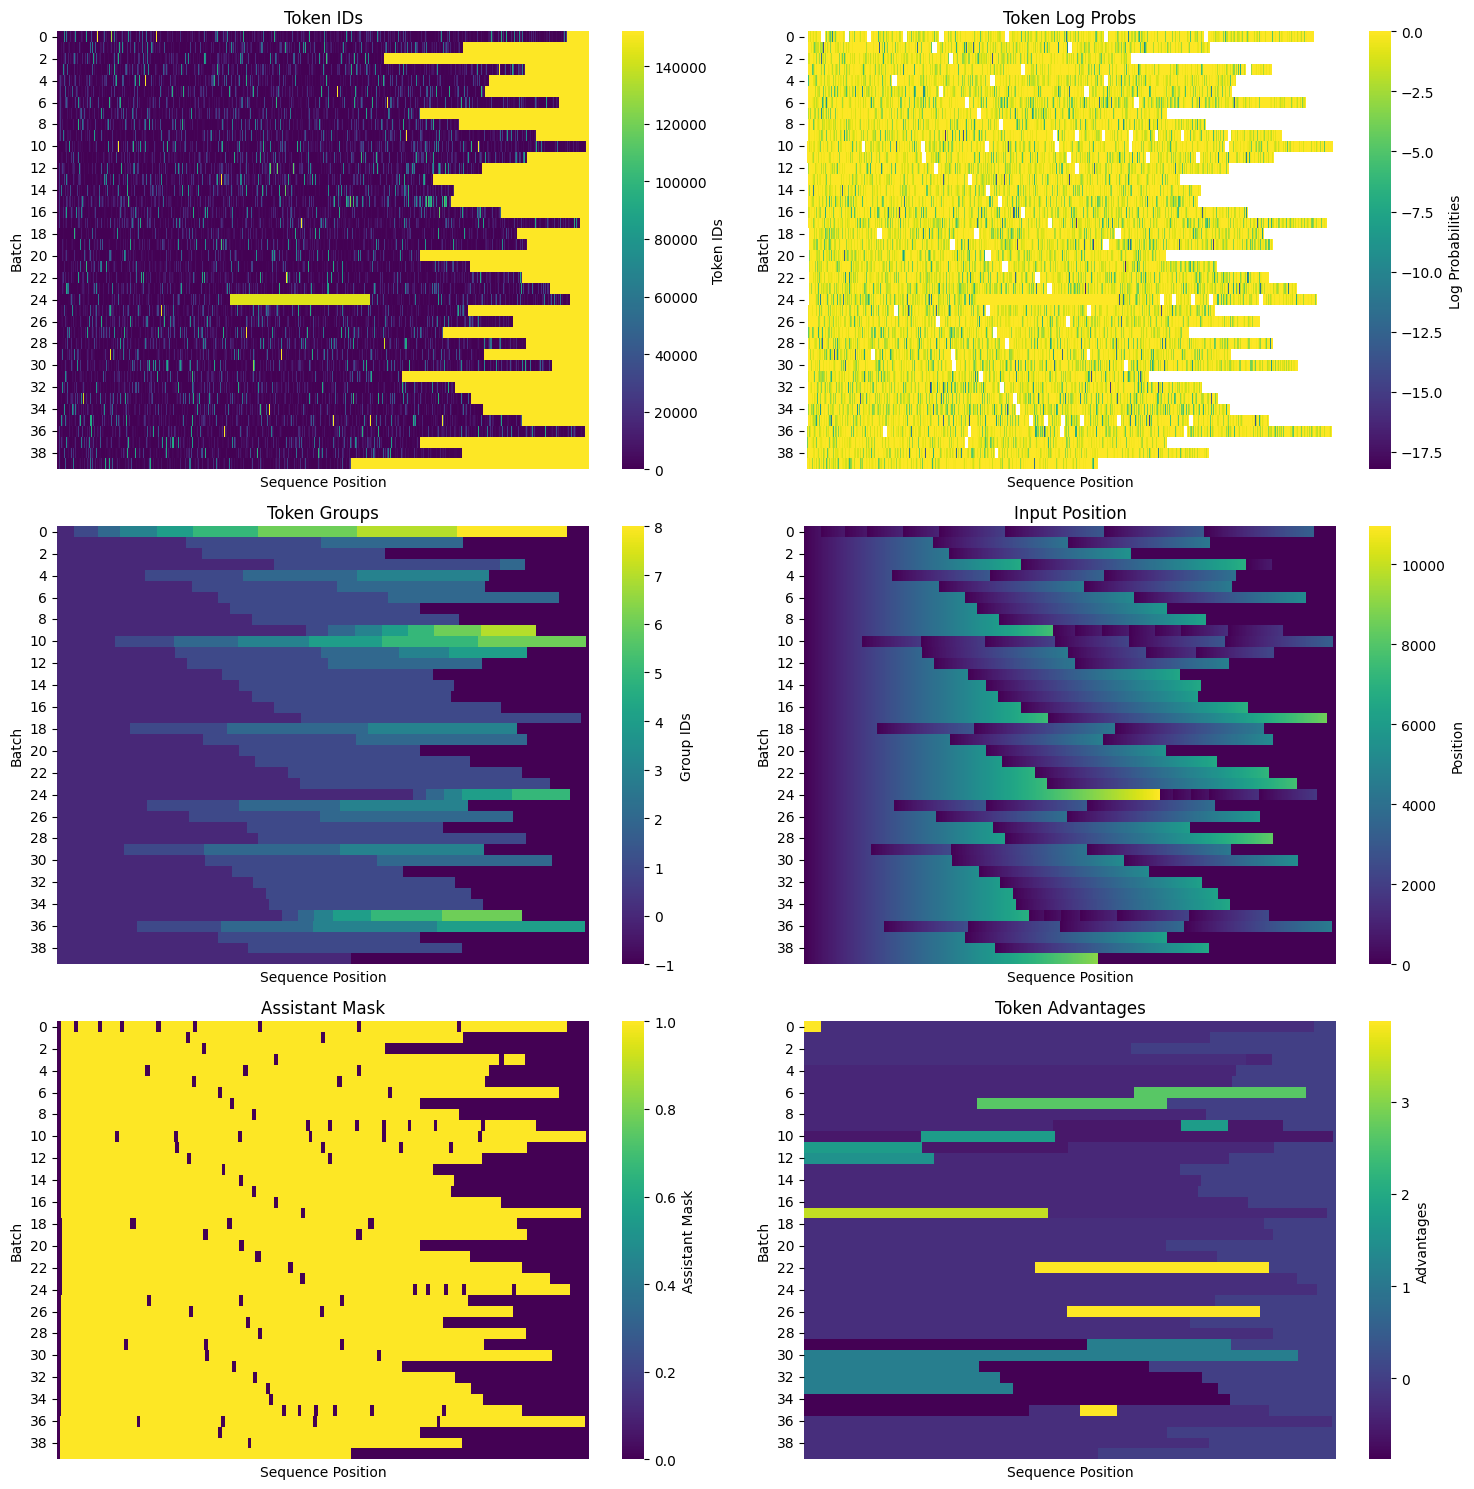

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739991439.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.89 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|20|Loss: 0.1917: 100%|██████████| 20/20 [07:55<00:00, 23.19s/it, entropy=2.29, kl_div=0.511, loss=0.192, policy=0.192]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.97 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 19:06:20 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 19:06:21 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 19:06:21 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.37s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.62s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.73s/it]



INFO 02-19 19:06:41 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 19:06:41 worker.py:267] Memory profiling takes 0.75 seconds
INFO 02-19 19:06:41 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 19:06:41 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 19:06:42 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 19:06:42 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 19:07:20 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 39.84 seconds
INFO 02-19 19:07:22 api_server.py:756] Using supplied chat template:
INFO 02-19 19:07:22 api_server.py:756] None
INFO 02-19 19:07:22 launcher.py:21] Available routes are:
INFO 02-19 19:07:22 launcher.py:29] Route: /

INFO:     Started server process [34364]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 19:07:23 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42760 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

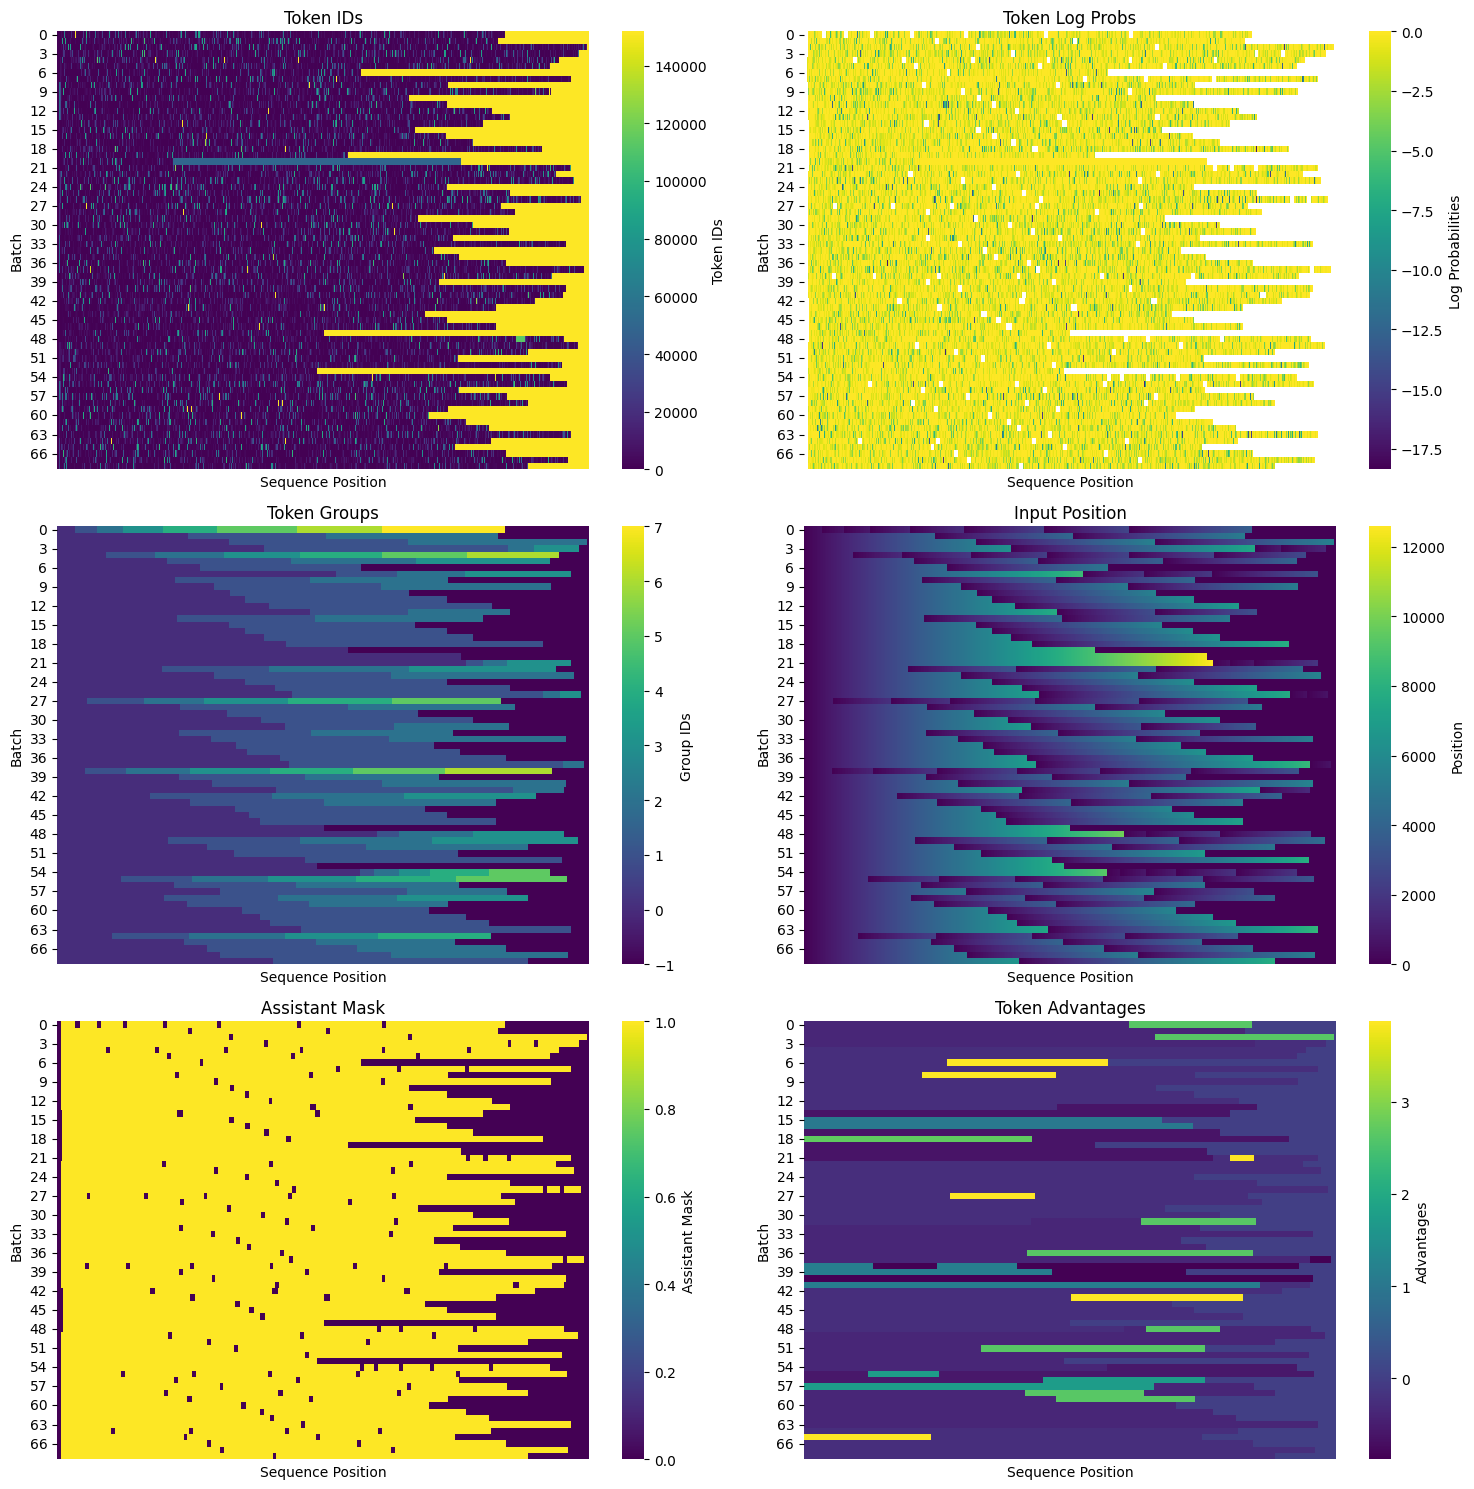

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739992598.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.64 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|34|Loss: 0.2215: 100%|██████████| 34/34 [13:20<00:00, 23.23s/it, entropy=2.31, kl_div=0.533, loss=0.222, policy=0.222]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.98 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 19:31:04 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 19:31:04 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 19:31:04 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.43s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.69s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.80s/it]



INFO 02-19 19:31:24 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 19:31:25 worker.py:267] Memory profiling takes 0.80 seconds
INFO 02-19 19:31:25 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 19:31:25 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 19:31:25 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 19:31:25 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 19:32:05 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.61 seconds
INFO 02-19 19:32:06 api_server.py:756] Using supplied chat template:
INFO 02-19 19:32:06 api_server.py:756] None
INFO 02-19 19:32:06 launcher.py:21] Available routes are:
INFO 02-19 19:32:06 launcher.py:29] Route: /

INFO:     Started server process [36362]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 19:32:07 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:34252 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

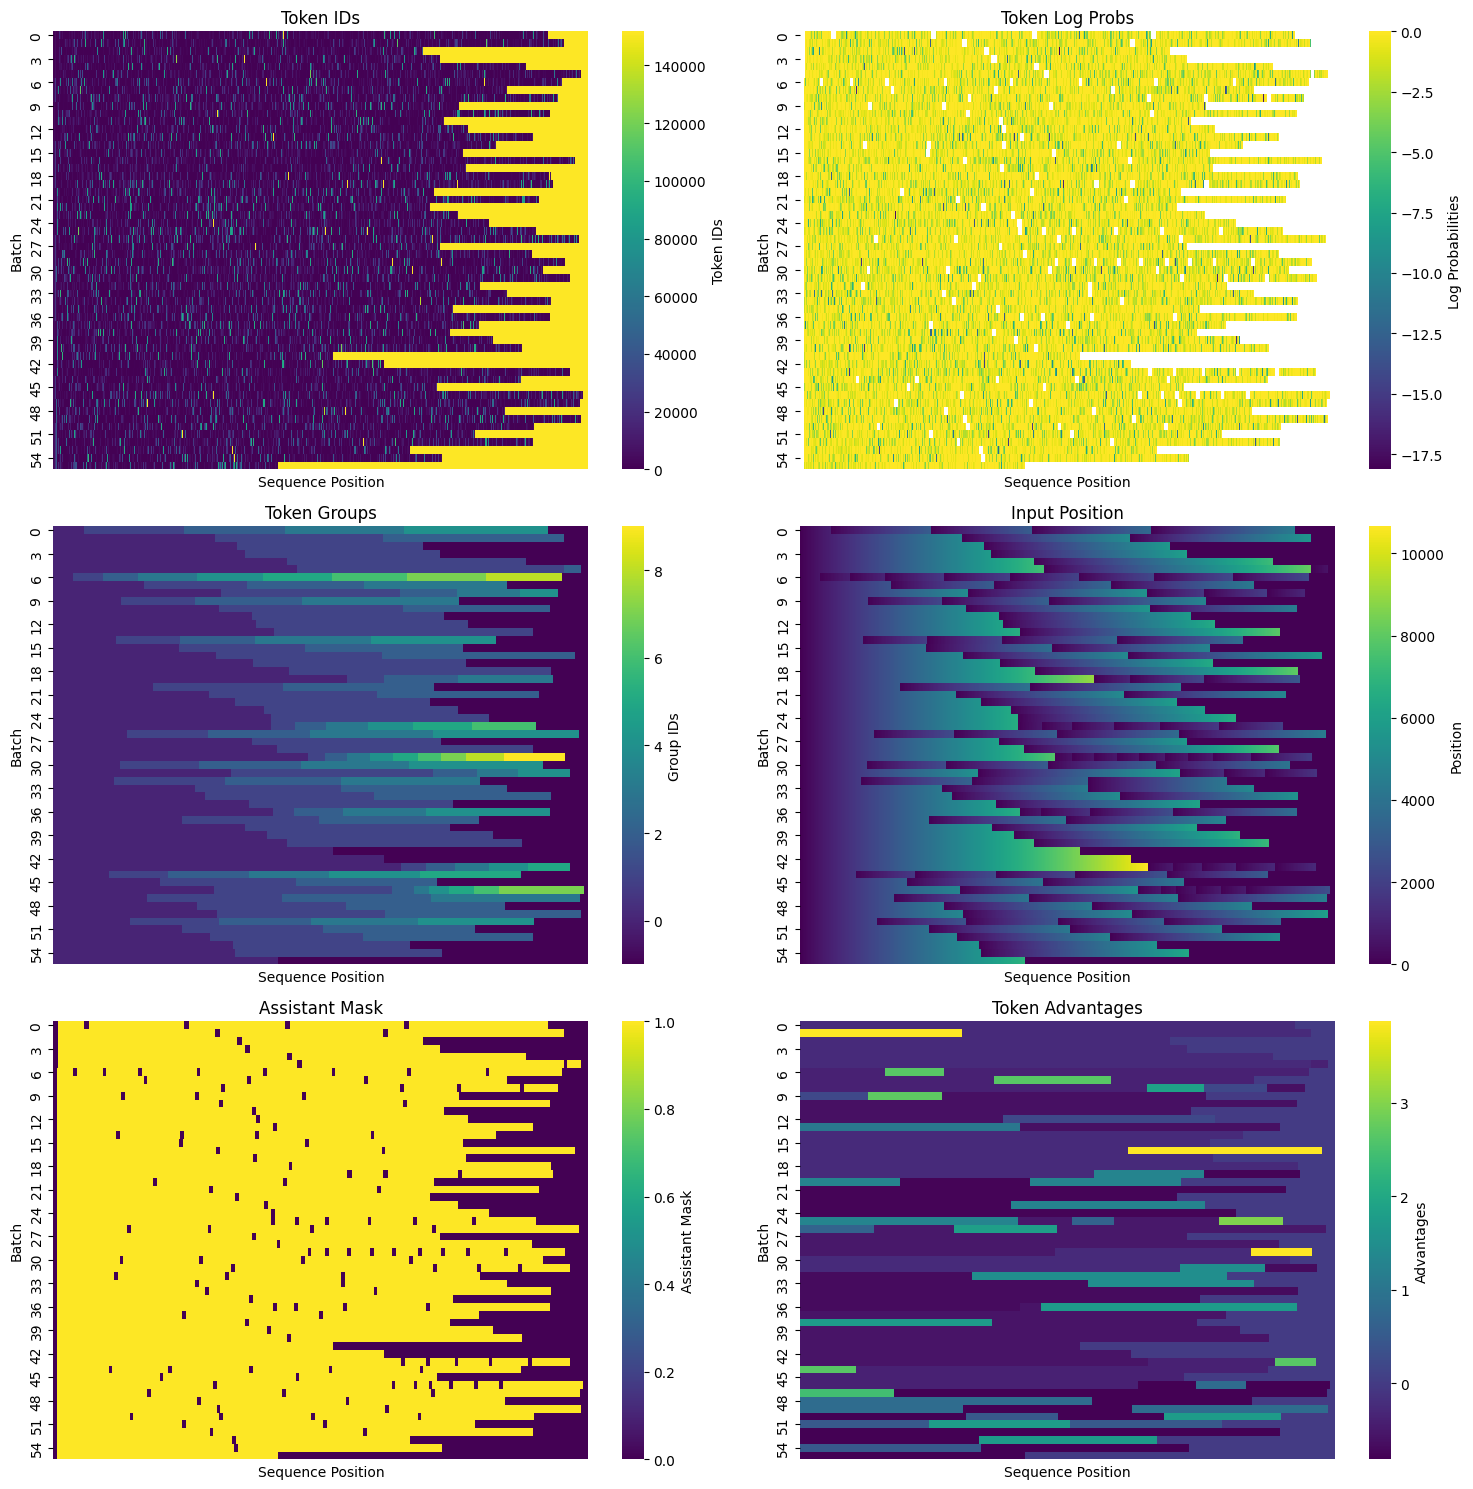

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739994108.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.23 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|28|Loss: 0.3032: 100%|██████████| 28/28 [11:01<00:00, 23.23s/it, entropy=1.94, kl_div=0.477, loss=0.303, policy=0.303]         INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.10 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB 

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 19:53:55 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 19:53:56 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 19:53:56 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.41s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.67s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.78s/it]



INFO 02-19 19:54:16 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 19:54:16 worker.py:267] Memory profiling takes 0.83 seconds
INFO 02-19 19:54:16 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 19:54:16 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 19:54:17 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 19:54:17 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 19:54:56 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.50 seconds
INFO 02-19 19:54:57 api_server.py:756] Using supplied chat template:
INFO 02-19 19:54:57 api_server.py:756] None
INFO 02-19 19:54:57 launcher.py:21] Available routes are:
INFO 02-19 19:54:57 launcher.py:29] Route: /

INFO:     Started server process [38060]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 19:54:59 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33832 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

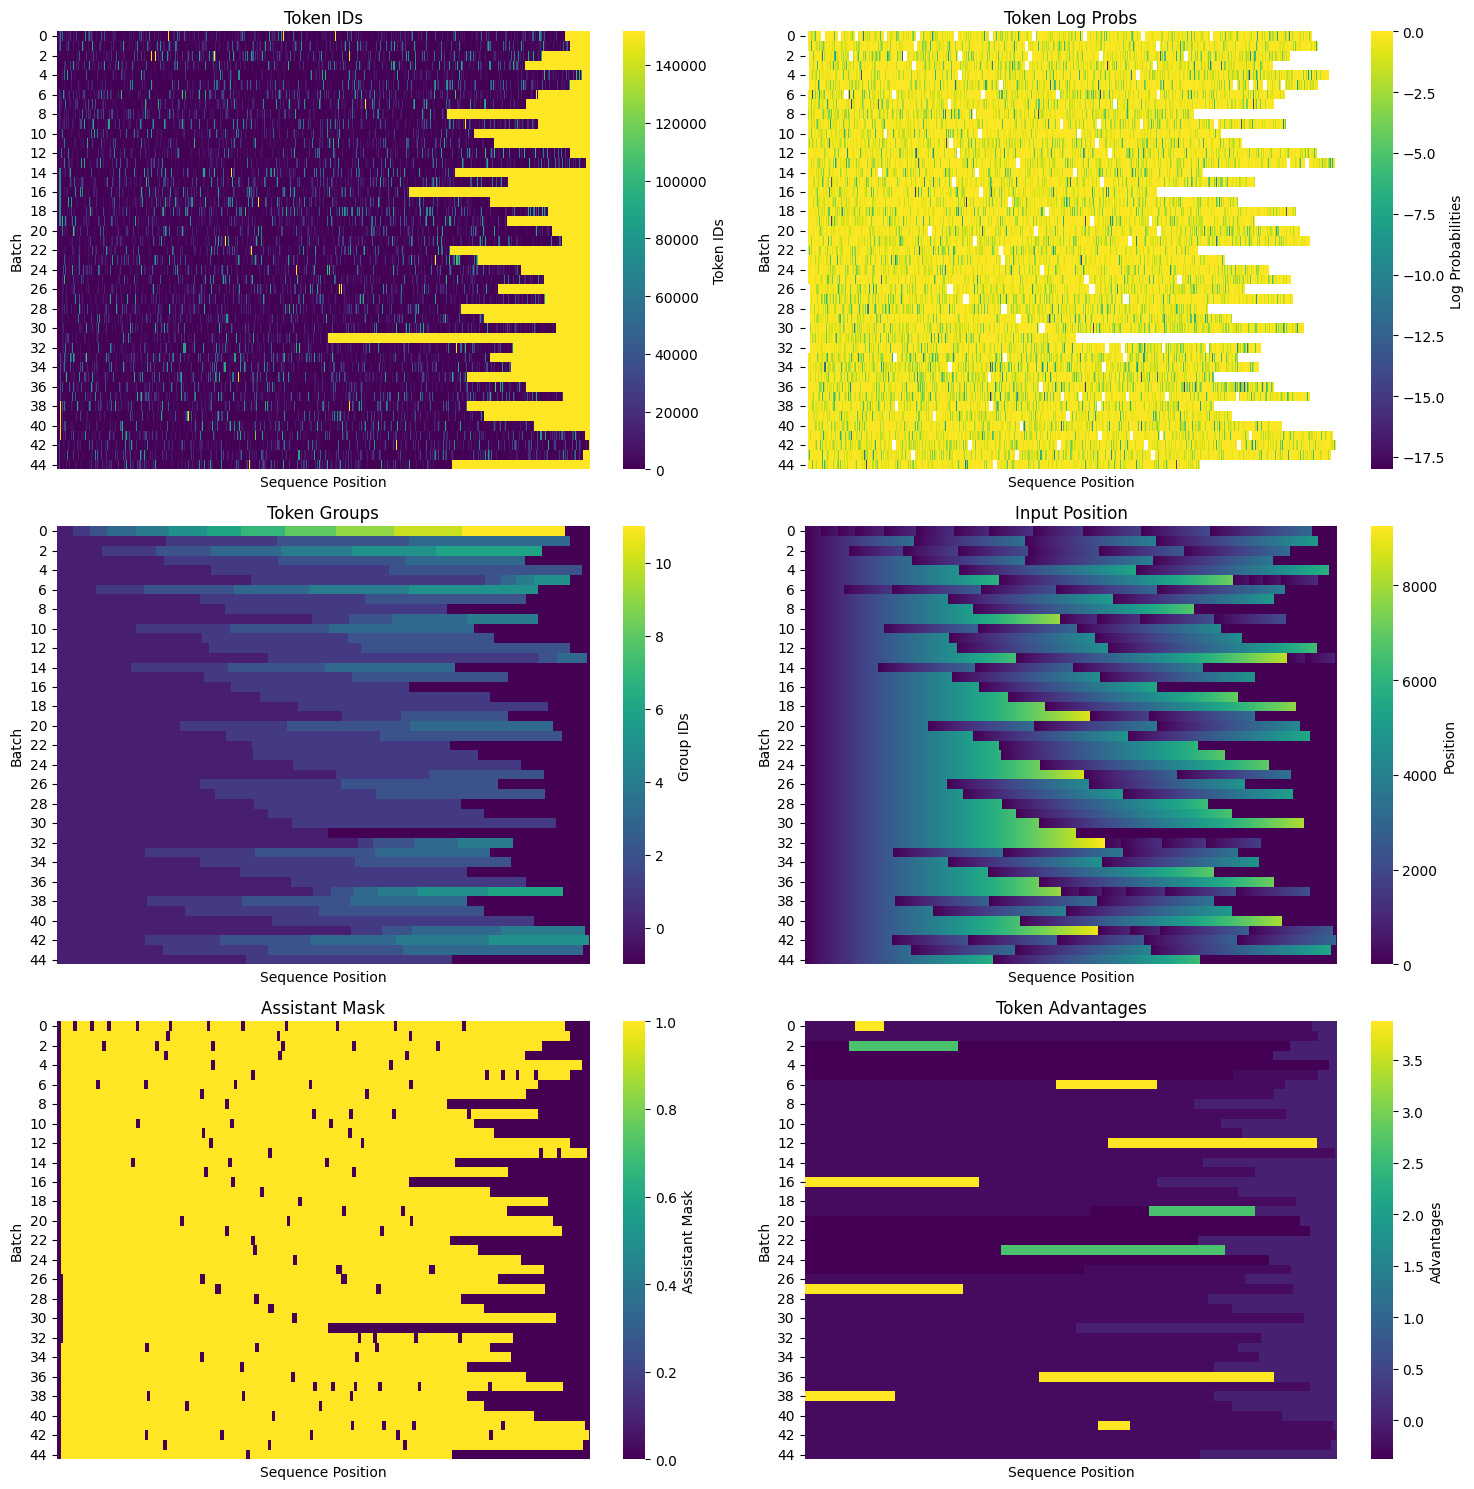

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739995434.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.78 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|22|Loss: 0.2246: 100%|██████████| 22/22 [08:42<00:00, 23.25s/it, entropy=1.84, kl_div=0.459, loss=0.225, policy=0.225]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.99 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved 

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 20:13:42 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 20:13:43 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 20:13:43 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.45s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-19 20:14:03 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 20:14:04 worker.py:267] Memory profiling takes 0.93 seconds
INFO 02-19 20:14:04 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 20:14:04 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 20:14:04 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 20:14:04 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 20:14:44 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.64 seconds
INFO 02-19 20:14:45 api_server.py:756] Using supplied chat template:
INFO 02-19 20:14:45 api_server.py:756] None
INFO 02-19 20:14:45 launcher.py:21] Available routes are:
INFO 02-19 20:14:45 launcher.py:29] Route: /

INFO:     Started server process [39549]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 20:14:46 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:39362 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

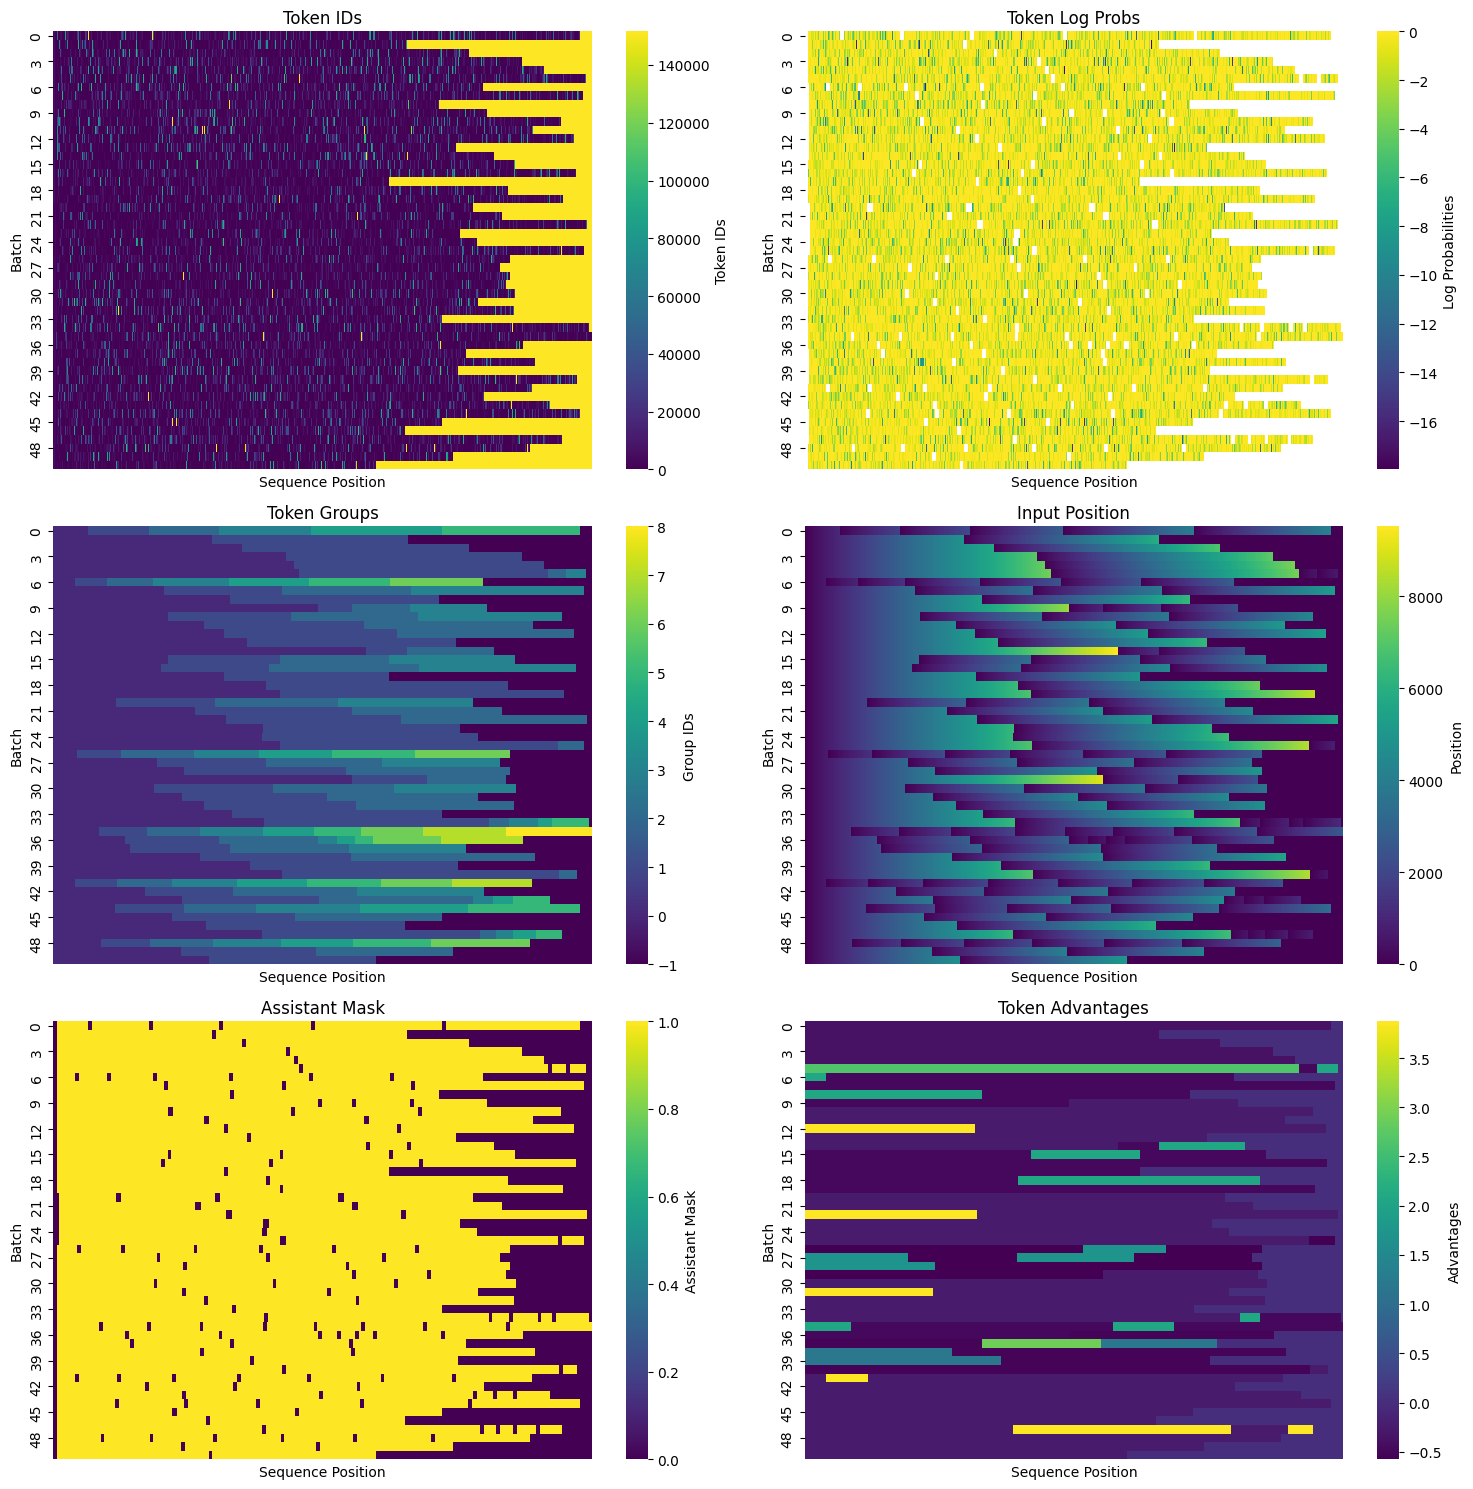

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739996606.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.69 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|25|Loss: 0.2351: 100%|██████████| 25/25 [09:52<00:00, 23.30s/it, entropy=1.57, kl_div=0.486, loss=0.235, policy=0.235]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.10 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 20:34:24 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 20:34:25 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 20:34:25 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.43s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-19 20:34:44 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 20:34:45 worker.py:267] Memory profiling takes 0.81 seconds
INFO 02-19 20:34:45 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 20:34:45 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 20:34:45 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 20:34:45 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 20:35:25 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.64 seconds
INFO 02-19 20:35:26 api_server.py:756] Using supplied chat template:
INFO 02-19 20:35:26 api_server.py:756] None
INFO 02-19 20:35:26 launcher.py:21] Available routes are:
INFO 02-19 20:35:26 launcher.py:29] Route: /

INFO:     Started server process [41028]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 20:35:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57384 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

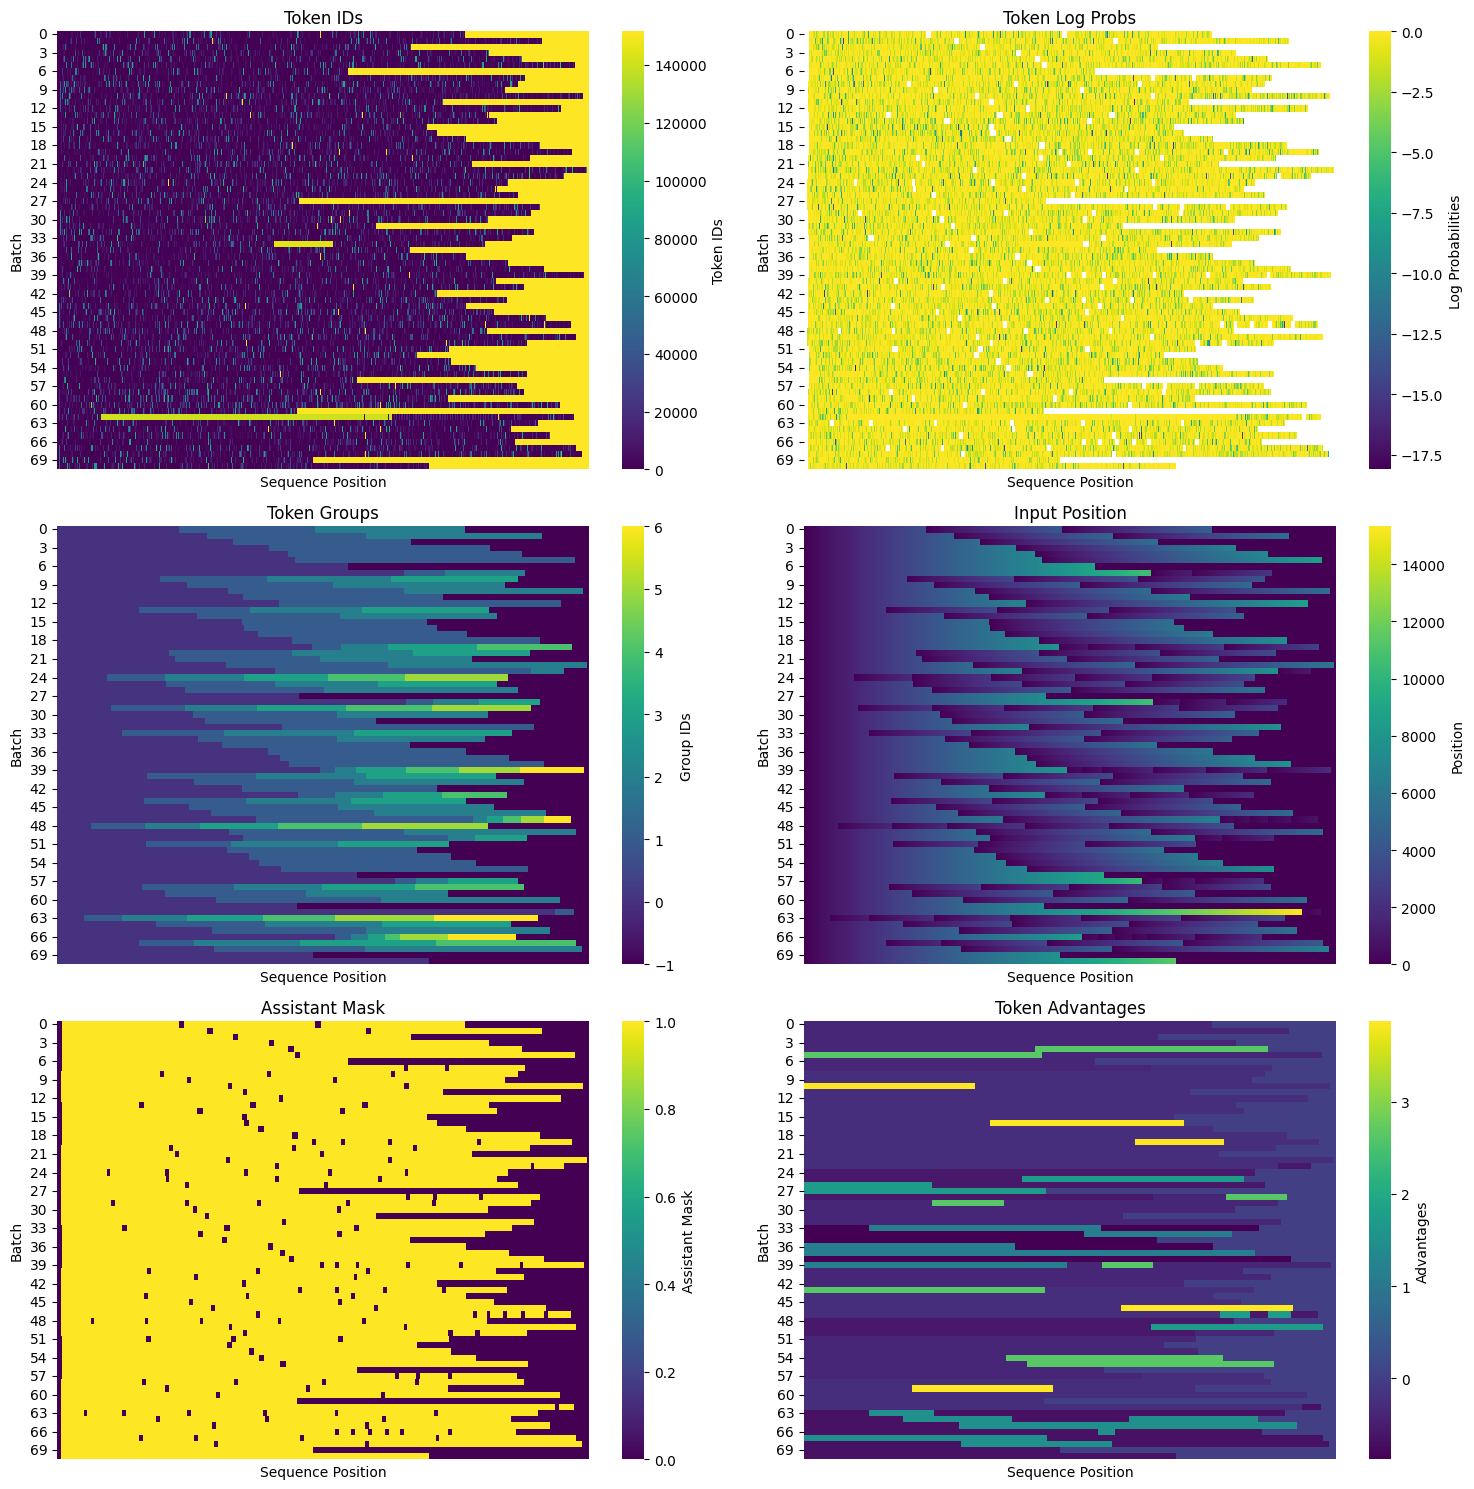

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739997897.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.79 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|35|Loss: 0.1602: 100%|██████████| 35/35 [13:43<00:00, 23.21s/it, entropy=2.28, kl_div=0.474, loss=0.16, policy=0.16]        INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.05 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB sav

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 20:59:46 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 20:59:47 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 20:59:47 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.45s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.69s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.81s/it]



INFO 02-19 21:00:07 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 21:00:08 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-19 21:00:08 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 21:00:08 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 21:00:08 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 21:00:08 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 21:00:47 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.41 seconds
INFO 02-19 21:00:48 api_server.py:756] Using supplied chat template:
INFO 02-19 21:00:48 api_server.py:756] None
INFO 02-19 21:00:48 launcher.py:21] Available routes are:
INFO 02-19 21:00:48 launcher.py:29] Route: /

INFO:     Started server process [42895]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 21:00:50 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45612 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

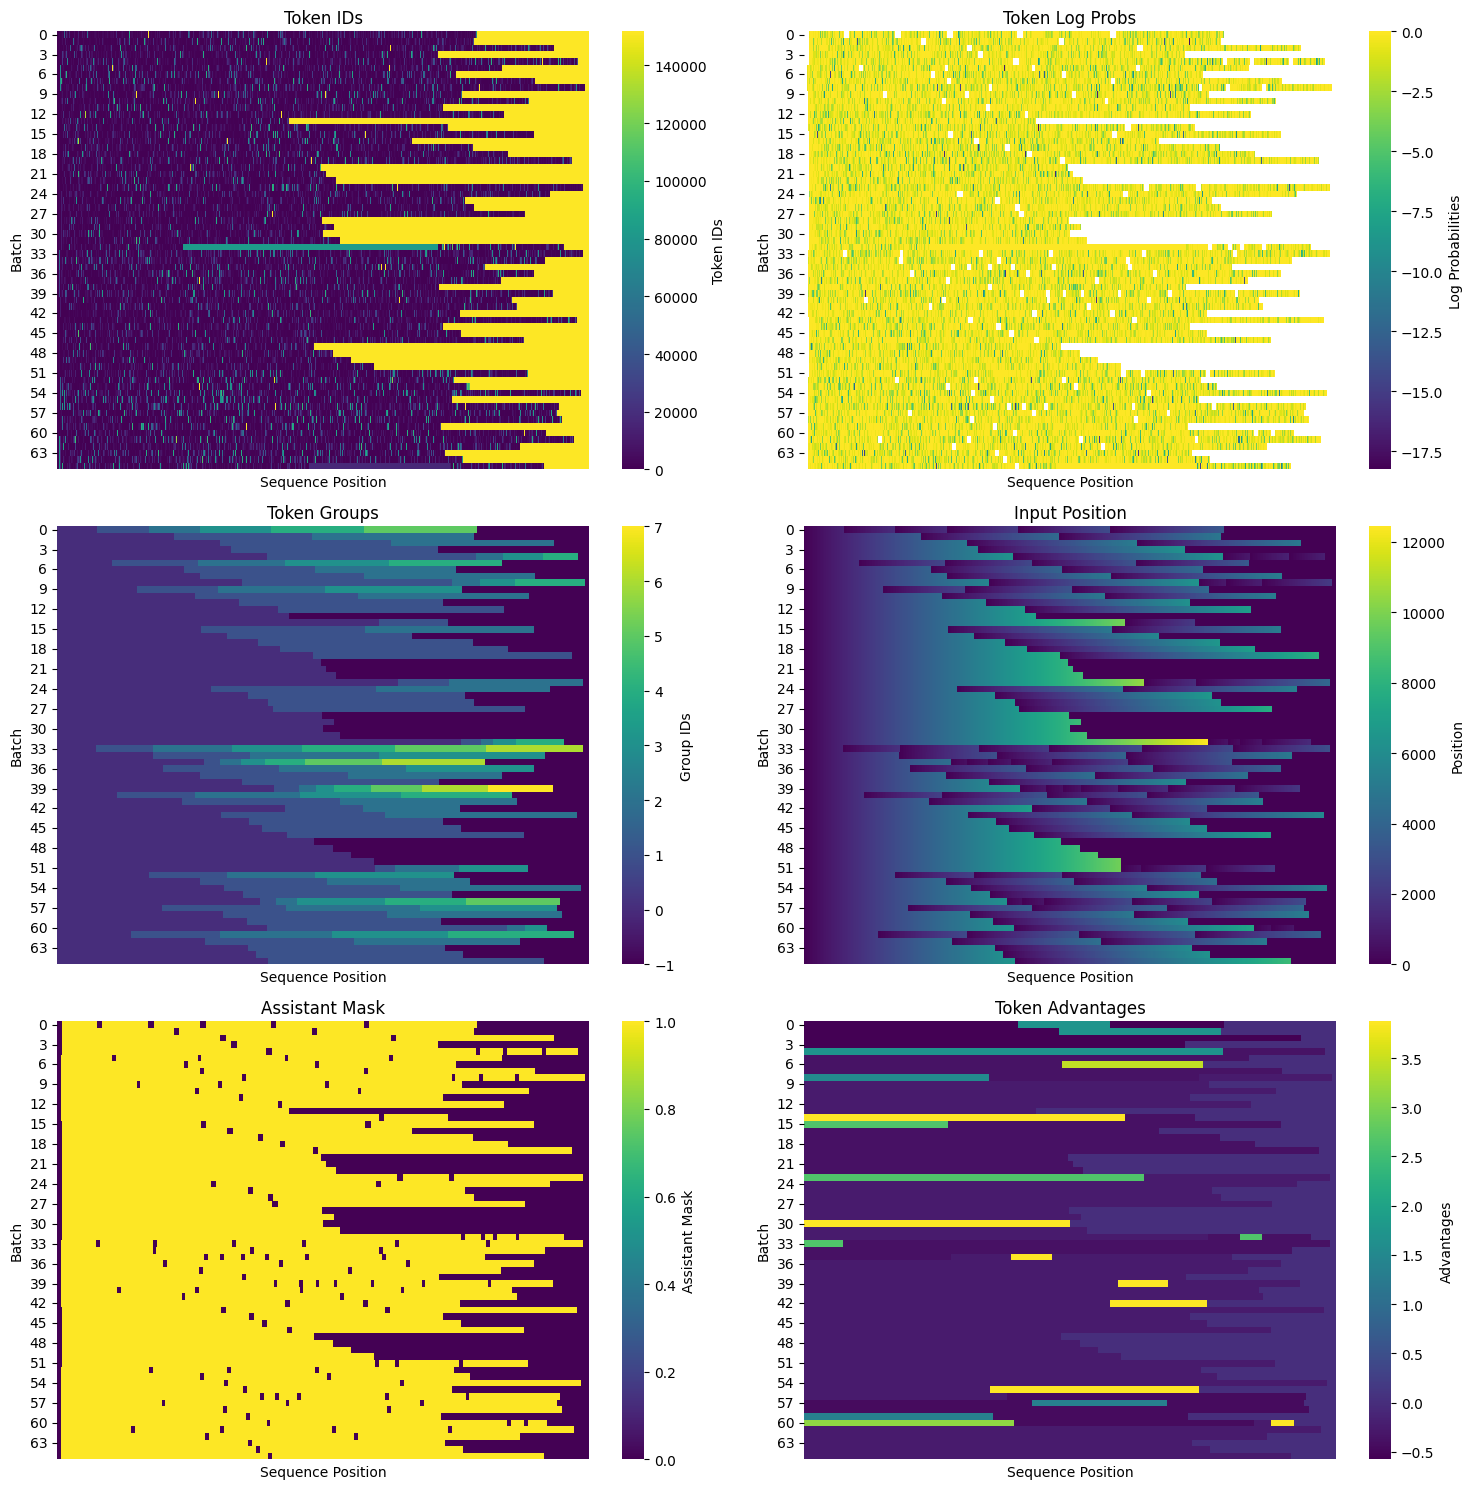

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1739999424.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.31 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|33|Loss: 0.3206: 100%|██████████| 33/33 [12:56<00:00, 23.22s/it, entropy=2.25, kl_div=0.425, loss=0.321, policy=0.321]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.12 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved to 

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 21:24:26 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 21:24:27 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 21:24:27 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.46s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-19 21:24:47 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 21:24:48 worker.py:267] Memory profiling takes 0.76 seconds
INFO 02-19 21:24:48 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 21:24:48 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 21:24:48 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 21:24:48 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 21:25:27 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.56 seconds
INFO 02-19 21:25:29 api_server.py:756] Using supplied chat template:
INFO 02-19 21:25:29 api_server.py:756] None
INFO 02-19 21:25:29 launcher.py:21] Available routes are:
INFO 02-19 21:25:29 launcher.py:29] Route: /

INFO:     Started server process [44483]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 21:25:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35856 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

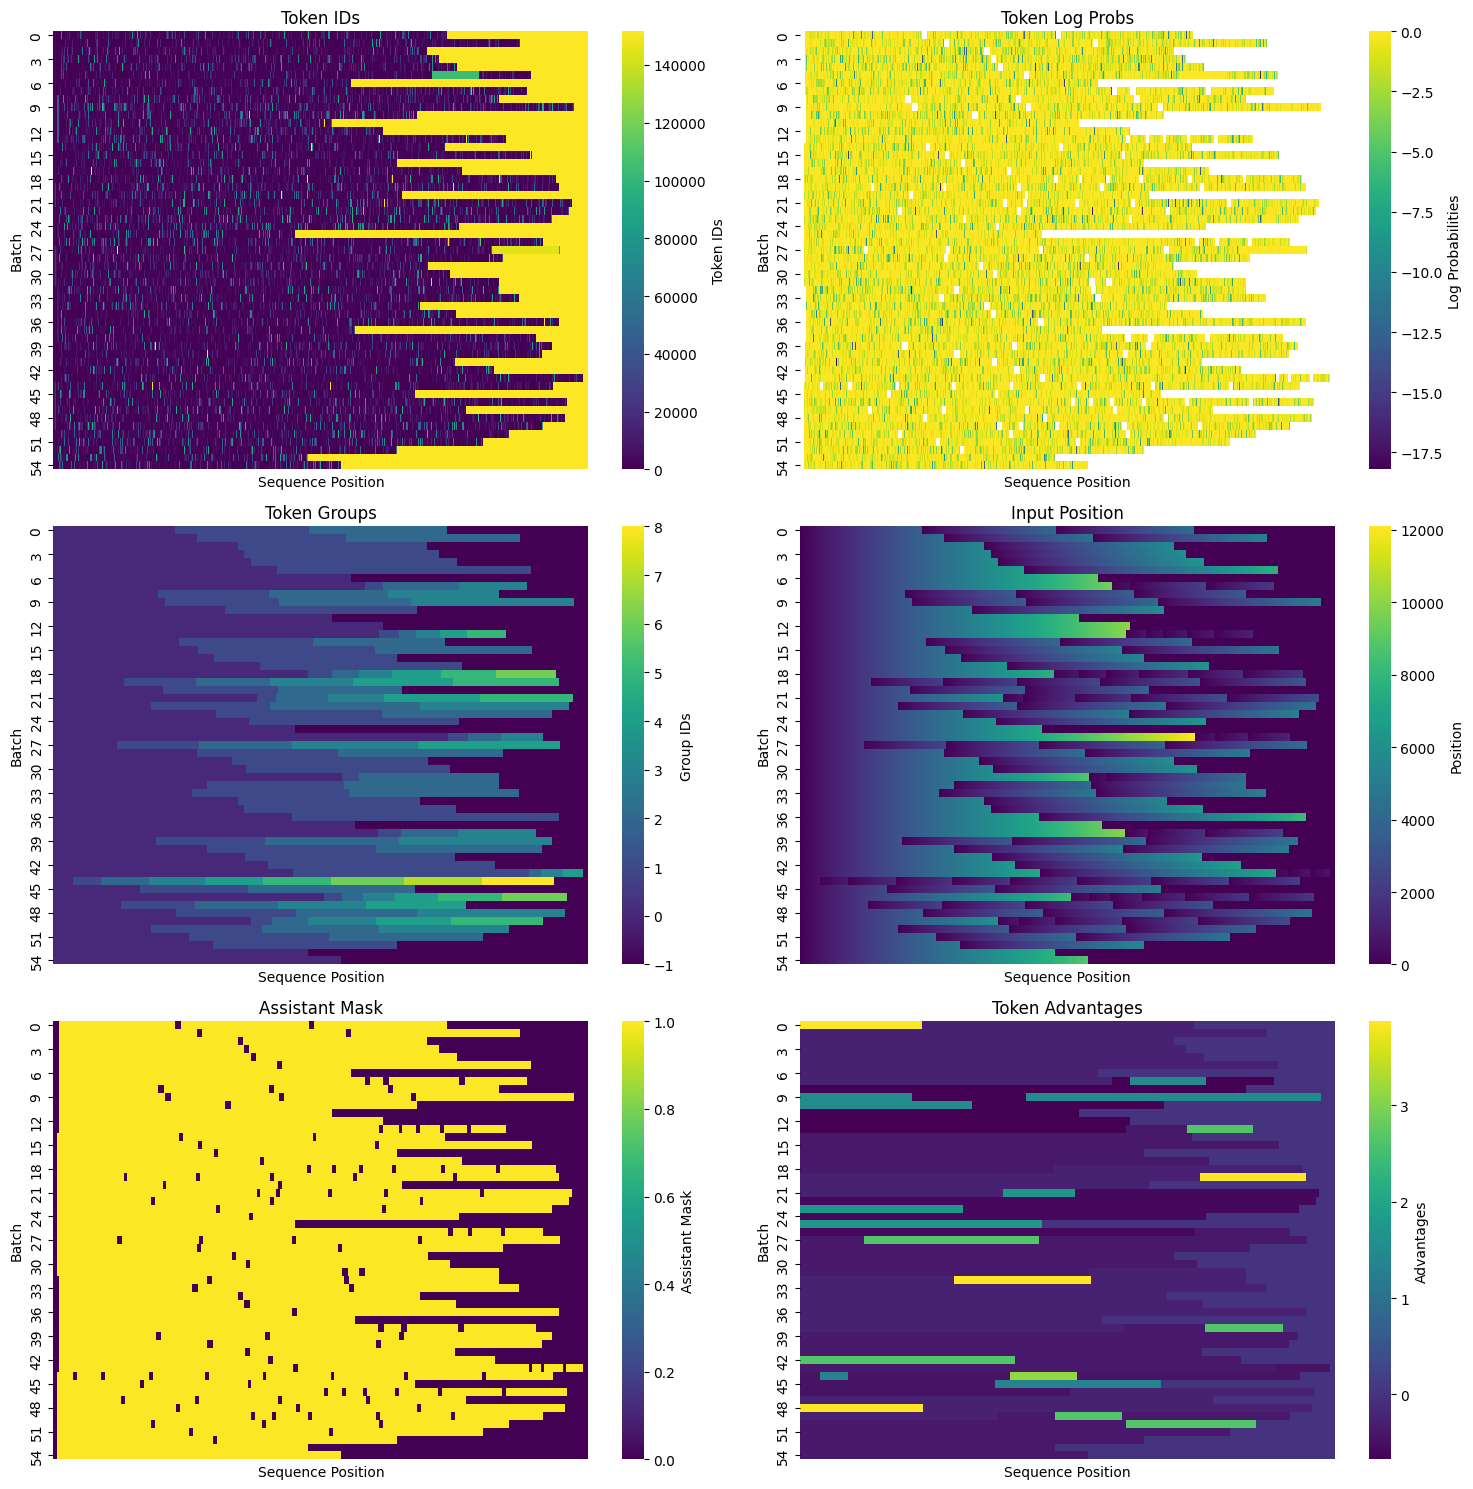

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740000879.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.35 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|27|Loss: 0.3273: 100%|██████████| 27/27 [10:37<00:00, 23.22s/it, entropy=2.61, kl_div=0.518, loss=0.327, policy=0.327]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.02 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 21:46:22 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 21:46:22 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 21:46:22 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.43s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-19 21:46:42 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 21:46:43 worker.py:267] Memory profiling takes 0.82 seconds
INFO 02-19 21:46:43 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 21:46:43 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 21:46:43 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 21:46:43 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 21:47:22 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.50 seconds
INFO 02-19 21:47:24 api_server.py:756] Using supplied chat template:
INFO 02-19 21:47:24 api_server.py:756] None
INFO 02-19 21:47:24 launcher.py:21] Available routes are:
INFO 02-19 21:47:24 launcher.py:29] Route: /

INFO:     Started server process [46327]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 21:47:26 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42702 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

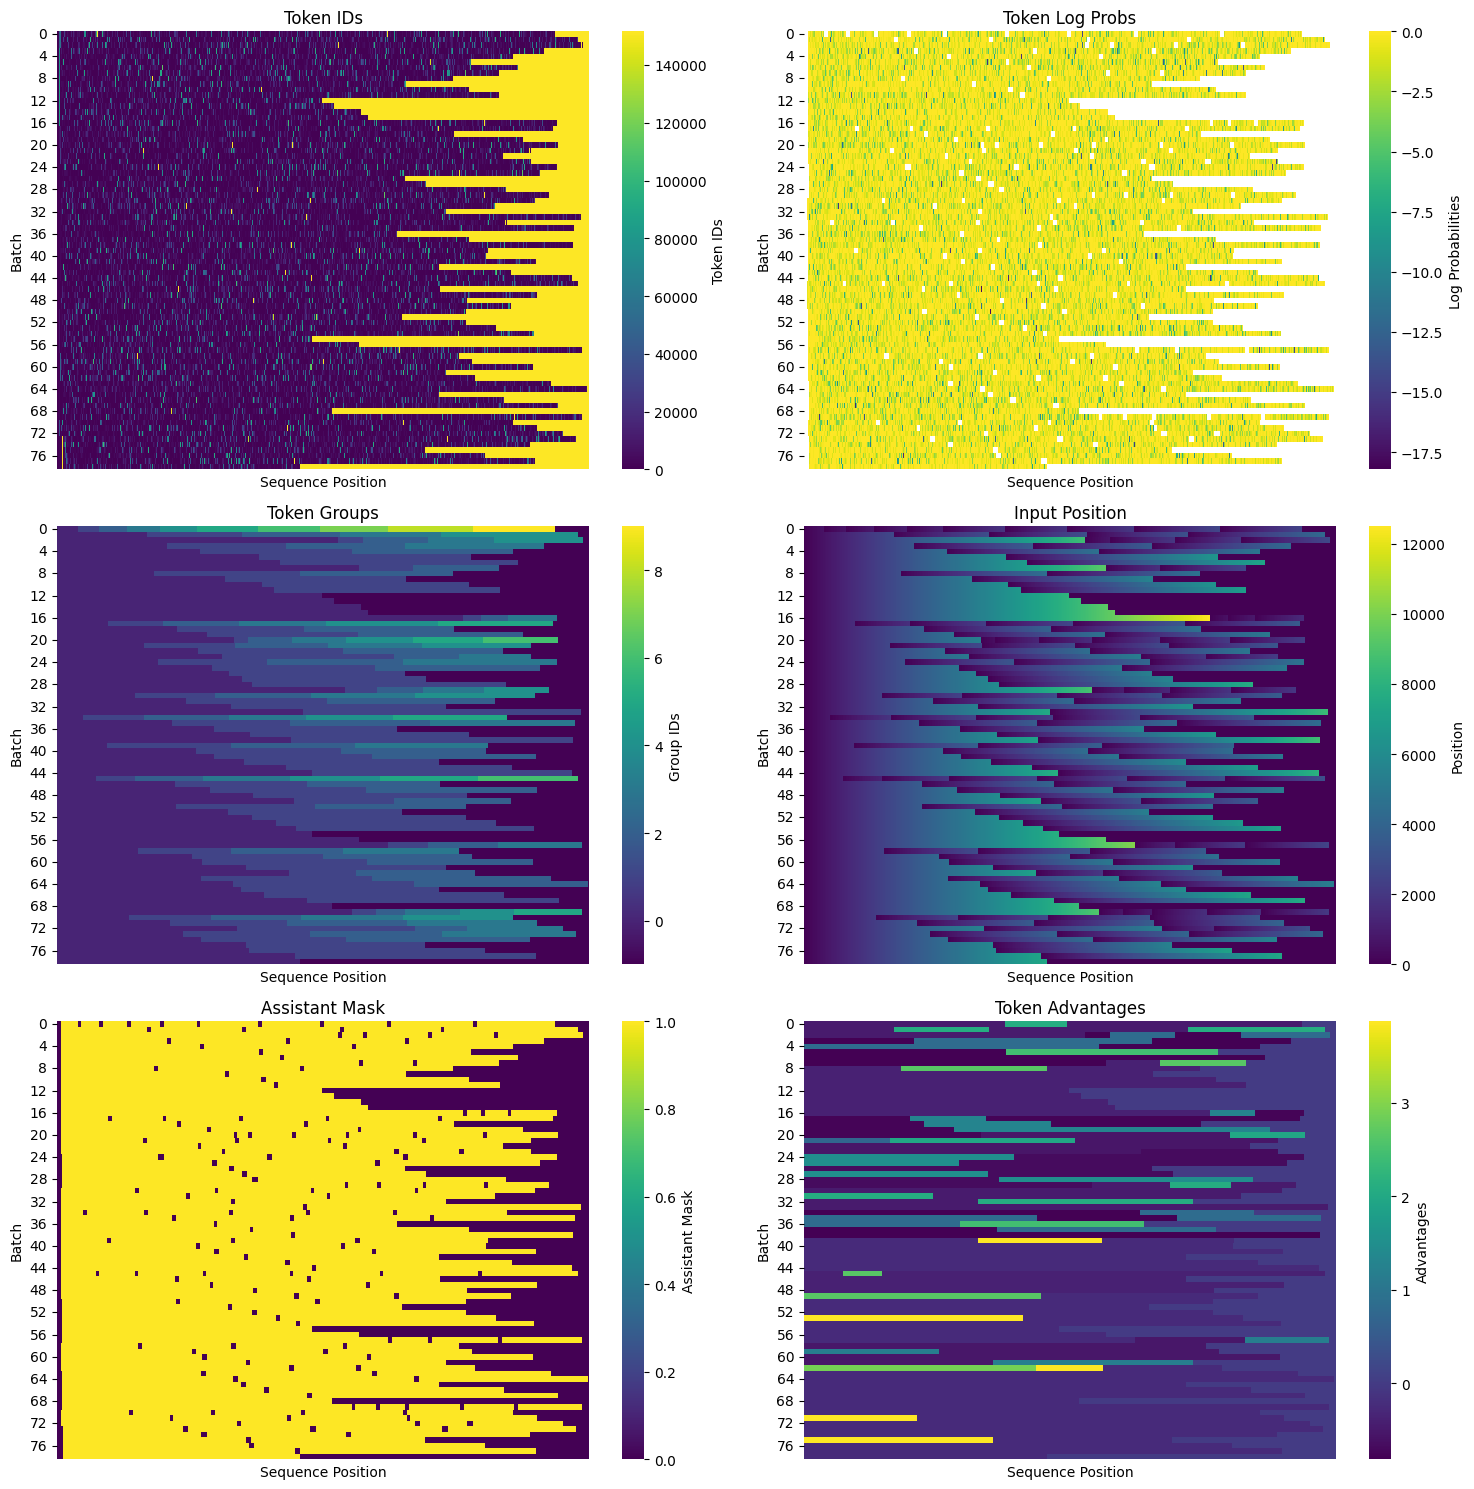

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740002171.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.52 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|39|Loss: 0.4047: 100%|██████████| 39/39 [15:15<00:00, 23.22s/it, entropy=2.39, kl_div=0.496, loss=0.405, policy=0.405]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.04 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 22:12:32 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 22:12:33 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 22:12:33 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.44s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.70s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.81s/it]



INFO 02-19 22:12:52 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 22:12:53 worker.py:267] Memory profiling takes 0.82 seconds
INFO 02-19 22:12:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 22:12:53 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 22:12:54 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 22:12:54 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 22:13:33 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.58 seconds
INFO 02-19 22:13:34 api_server.py:756] Using supplied chat template:
INFO 02-19 22:13:34 api_server.py:756] None
INFO 02-19 22:13:34 launcher.py:21] Available routes are:
INFO 02-19 22:13:34 launcher.py:29] Route: /

INFO:     Started server process [48240]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 22:13:36 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57672 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

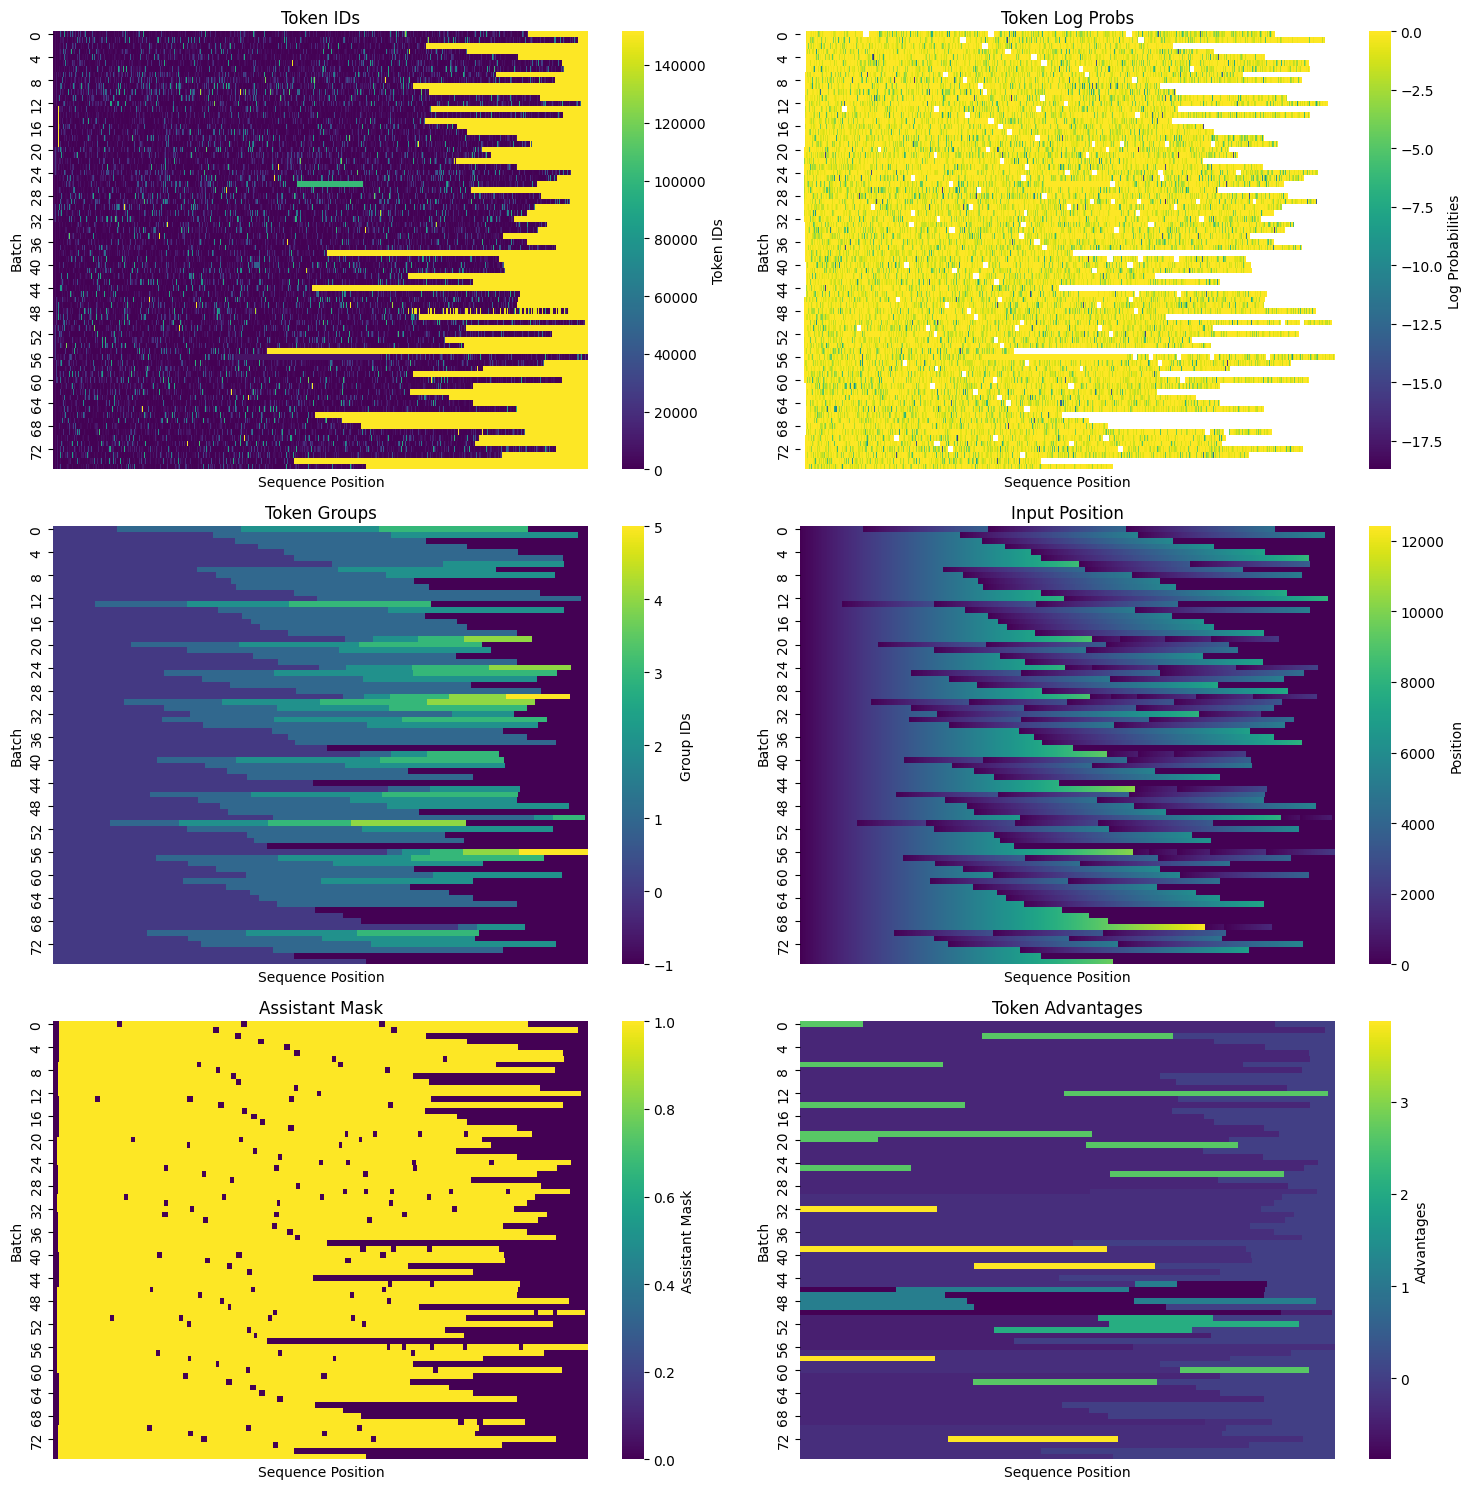

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740003787.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.29 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|38|Loss: 0.1720: 100%|██████████| 38/38 [14:52<00:00, 23.17s/it, entropy=2.98, kl_div=0.494, loss=0.172, policy=0.172]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.90 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 22:39:04 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 22:39:05 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 22:39:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.44s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.67s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.79s/it]



INFO 02-19 22:39:25 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 22:39:25 worker.py:267] Memory profiling takes 0.74 seconds
INFO 02-19 22:39:25 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 22:39:25 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 22:39:26 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 22:39:26 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 22:40:05 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.20 seconds
INFO 02-19 22:40:06 api_server.py:756] Using supplied chat template:
INFO 02-19 22:40:06 api_server.py:756] None
INFO 02-19 22:40:06 launcher.py:21] Available routes are:
INFO 02-19 22:40:06 launcher.py:29] Route: /

INFO:     Started server process [50135]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 22:40:08 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:56476 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

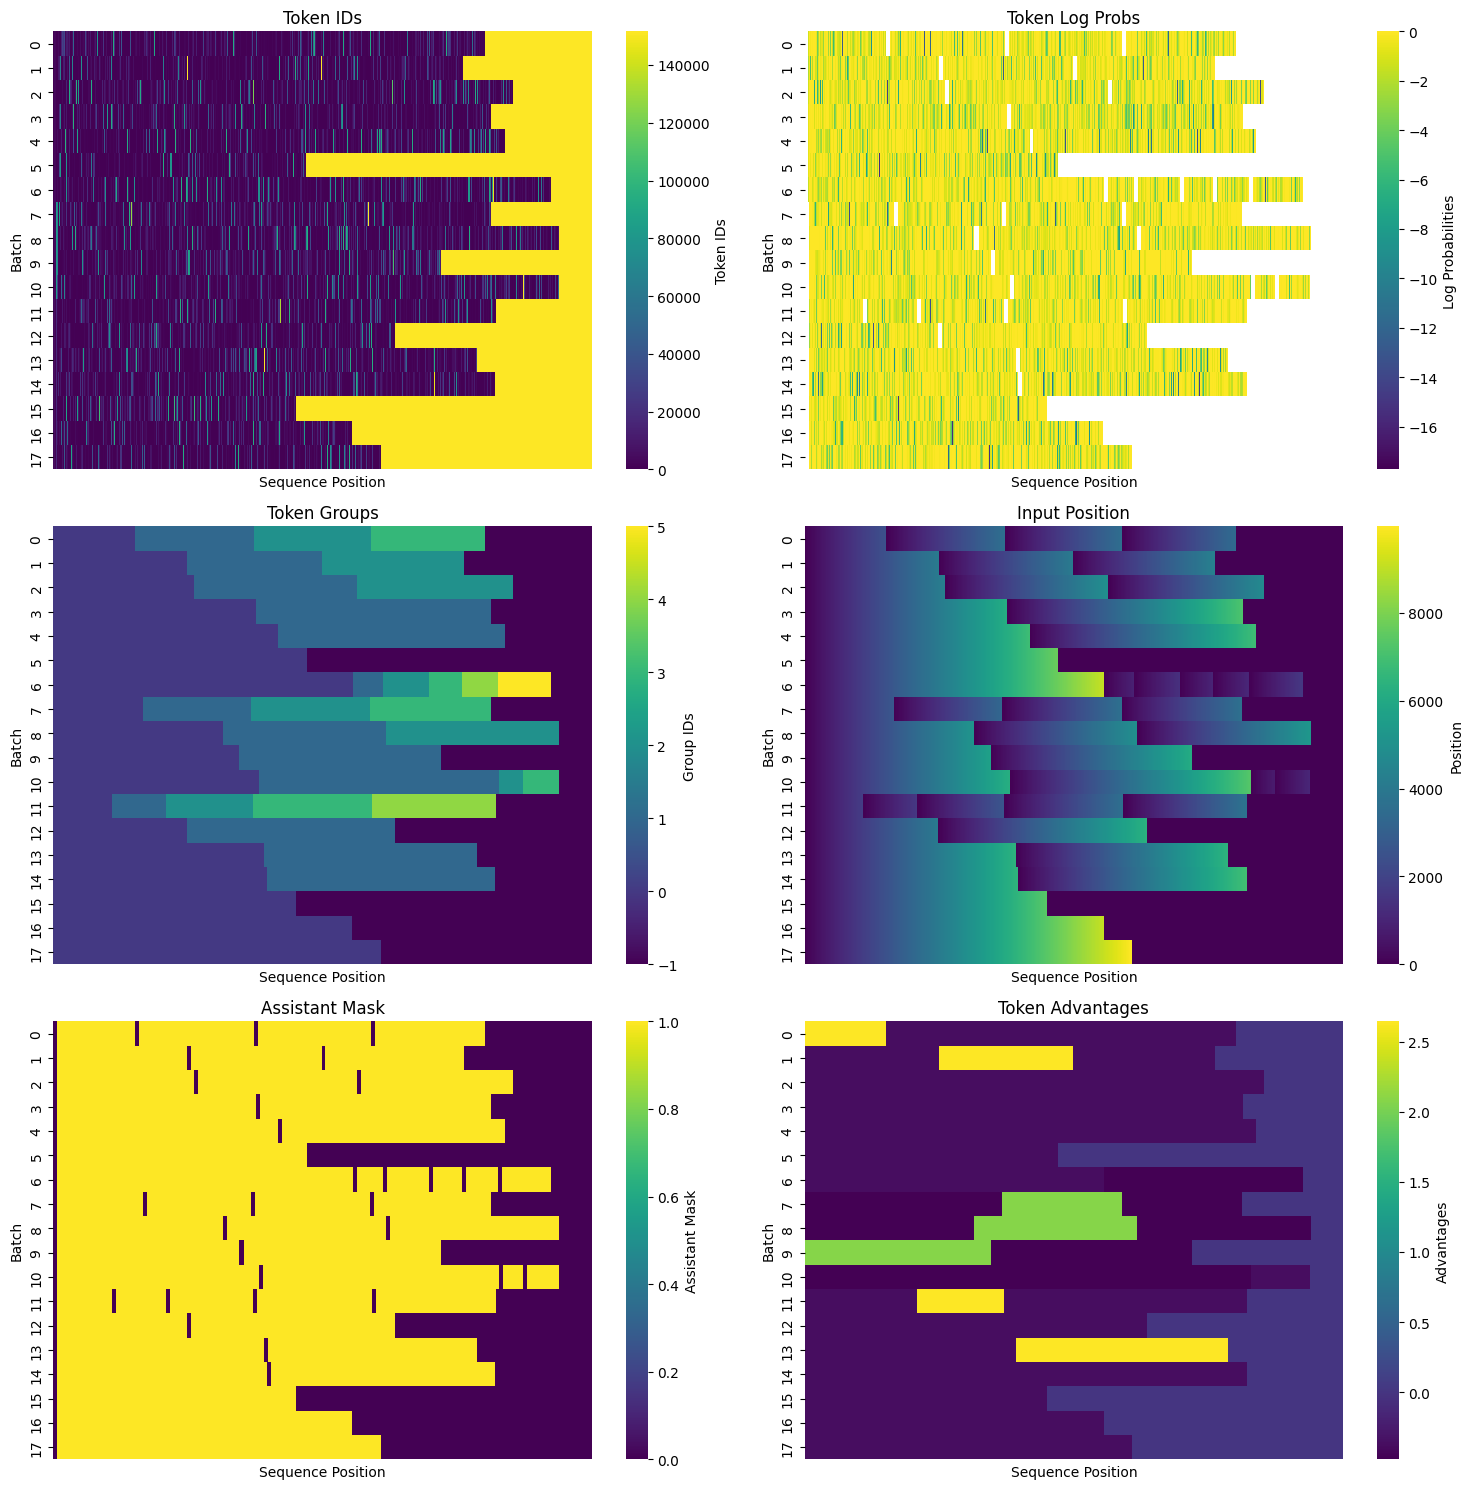

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740005433.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.46 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|9|Loss: 0.3115: 100%|██████████| 9/9 [03:39<00:00, 23.36s/it, entropy=3.06, kl_div=0.541, loss=0.311, policy=0.311]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.98 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved to 

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 22:55:18 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 22:55:19 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 22:55:19 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.43s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.67s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.78s/it]



INFO 02-19 22:55:39 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 22:55:40 worker.py:267] Memory profiling takes 0.75 seconds
INFO 02-19 22:55:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 22:55:40 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 22:55:40 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 22:55:40 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 22:56:19 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.26 seconds
INFO 02-19 22:56:20 api_server.py:756] Using supplied chat template:
INFO 02-19 22:56:20 api_server.py:756] None
INFO 02-19 22:56:20 launcher.py:21] Available routes are:
INFO 02-19 22:56:20 launcher.py:29] Route: /

INFO:     Started server process [51188]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 22:56:23 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:59892 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

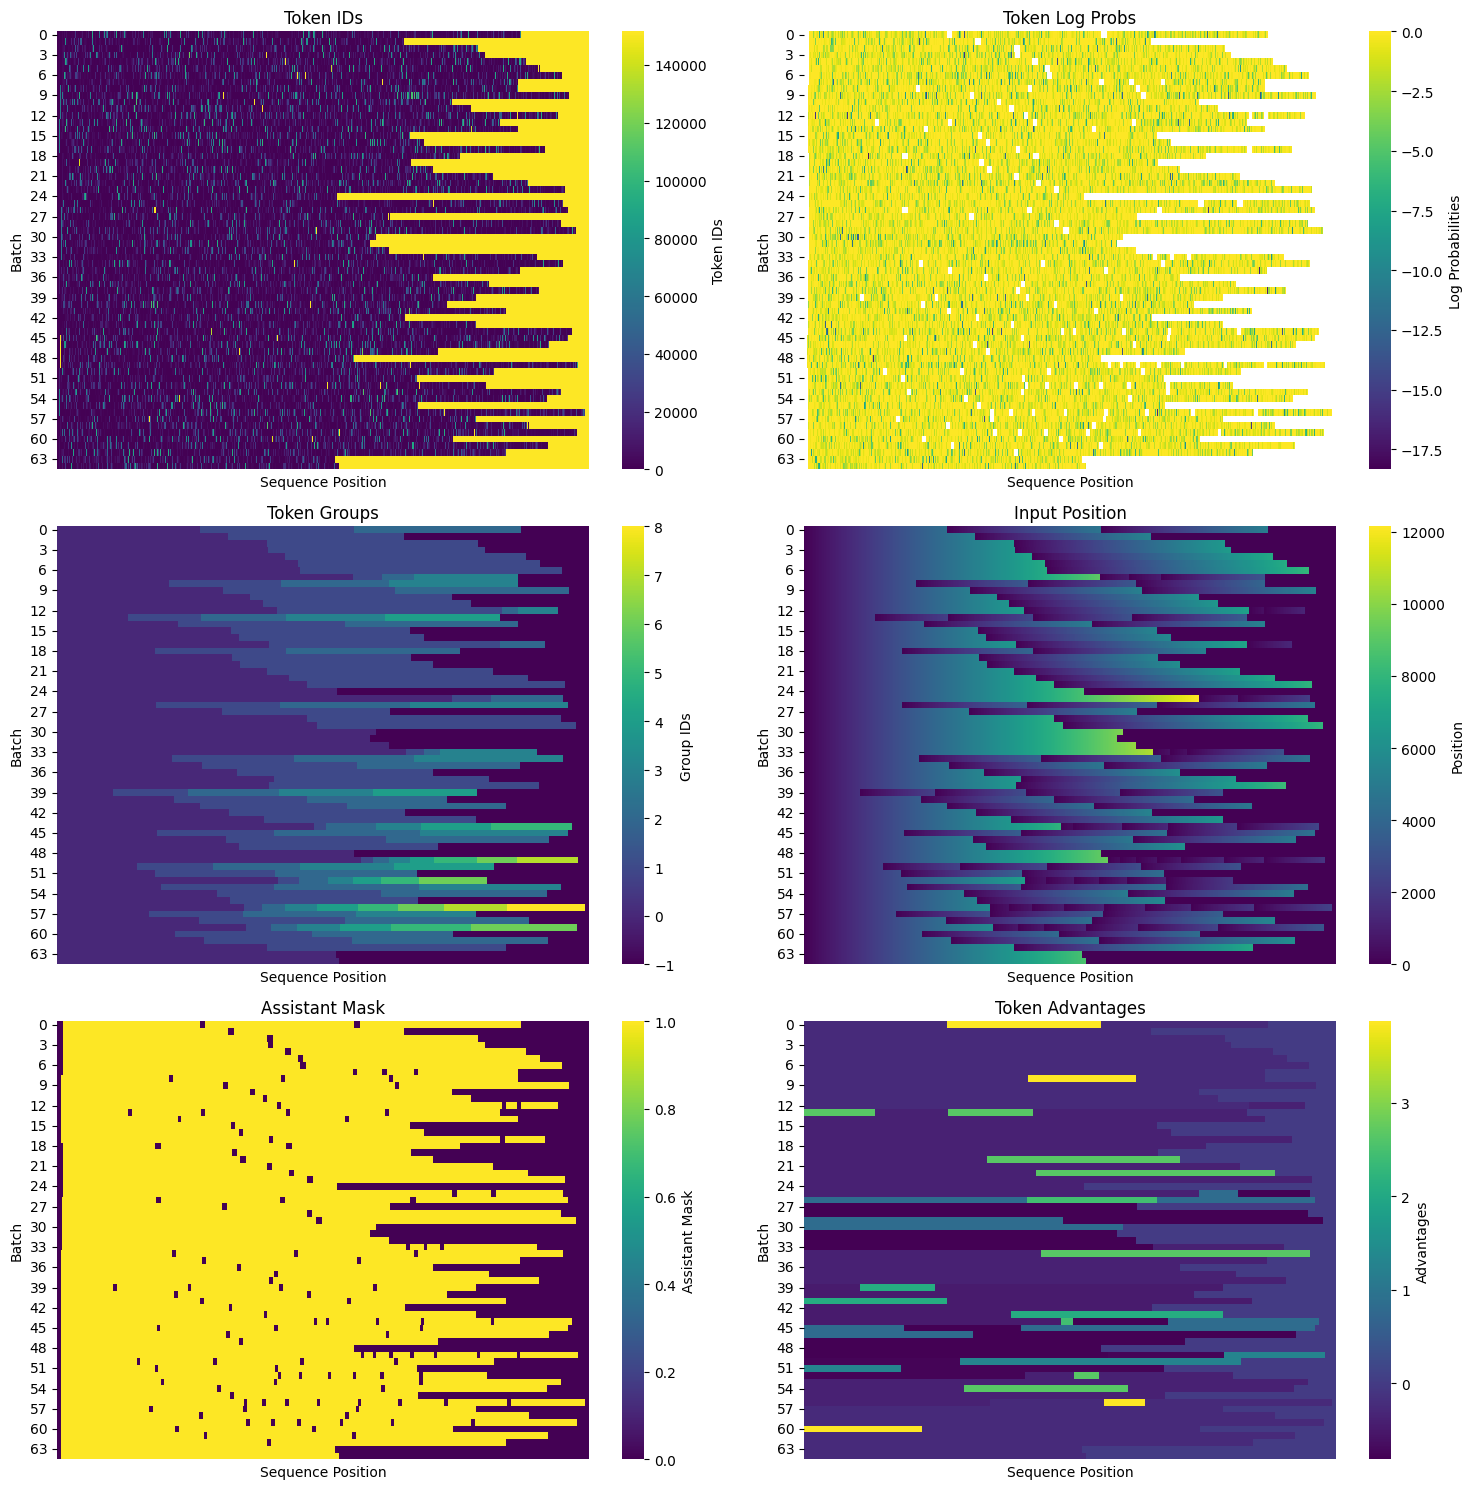

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740006364.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 32.11 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|32|Loss: 0.2134: 100%|██████████| 32/32 [12:34<00:00, 23.23s/it, entropy=2.76, kl_div=0.513, loss=0.213, policy=0.213]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.05 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved 

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 23:19:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 23:19:45 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 23:19:45 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.45s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.74s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.84s/it]



INFO 02-19 23:20:05 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 23:20:06 worker.py:267] Memory profiling takes 0.87 seconds
INFO 02-19 23:20:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 23:20:06 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 23:20:06 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 23:20:06 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 23:20:46 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.82 seconds
INFO 02-19 23:20:47 api_server.py:756] Using supplied chat template:
INFO 02-19 23:20:47 api_server.py:756] None
INFO 02-19 23:20:47 launcher.py:21] Available routes are:
INFO 02-19 23:20:47 launcher.py:29] Route: /

INFO:     Started server process [53164]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 23:20:50 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33408 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

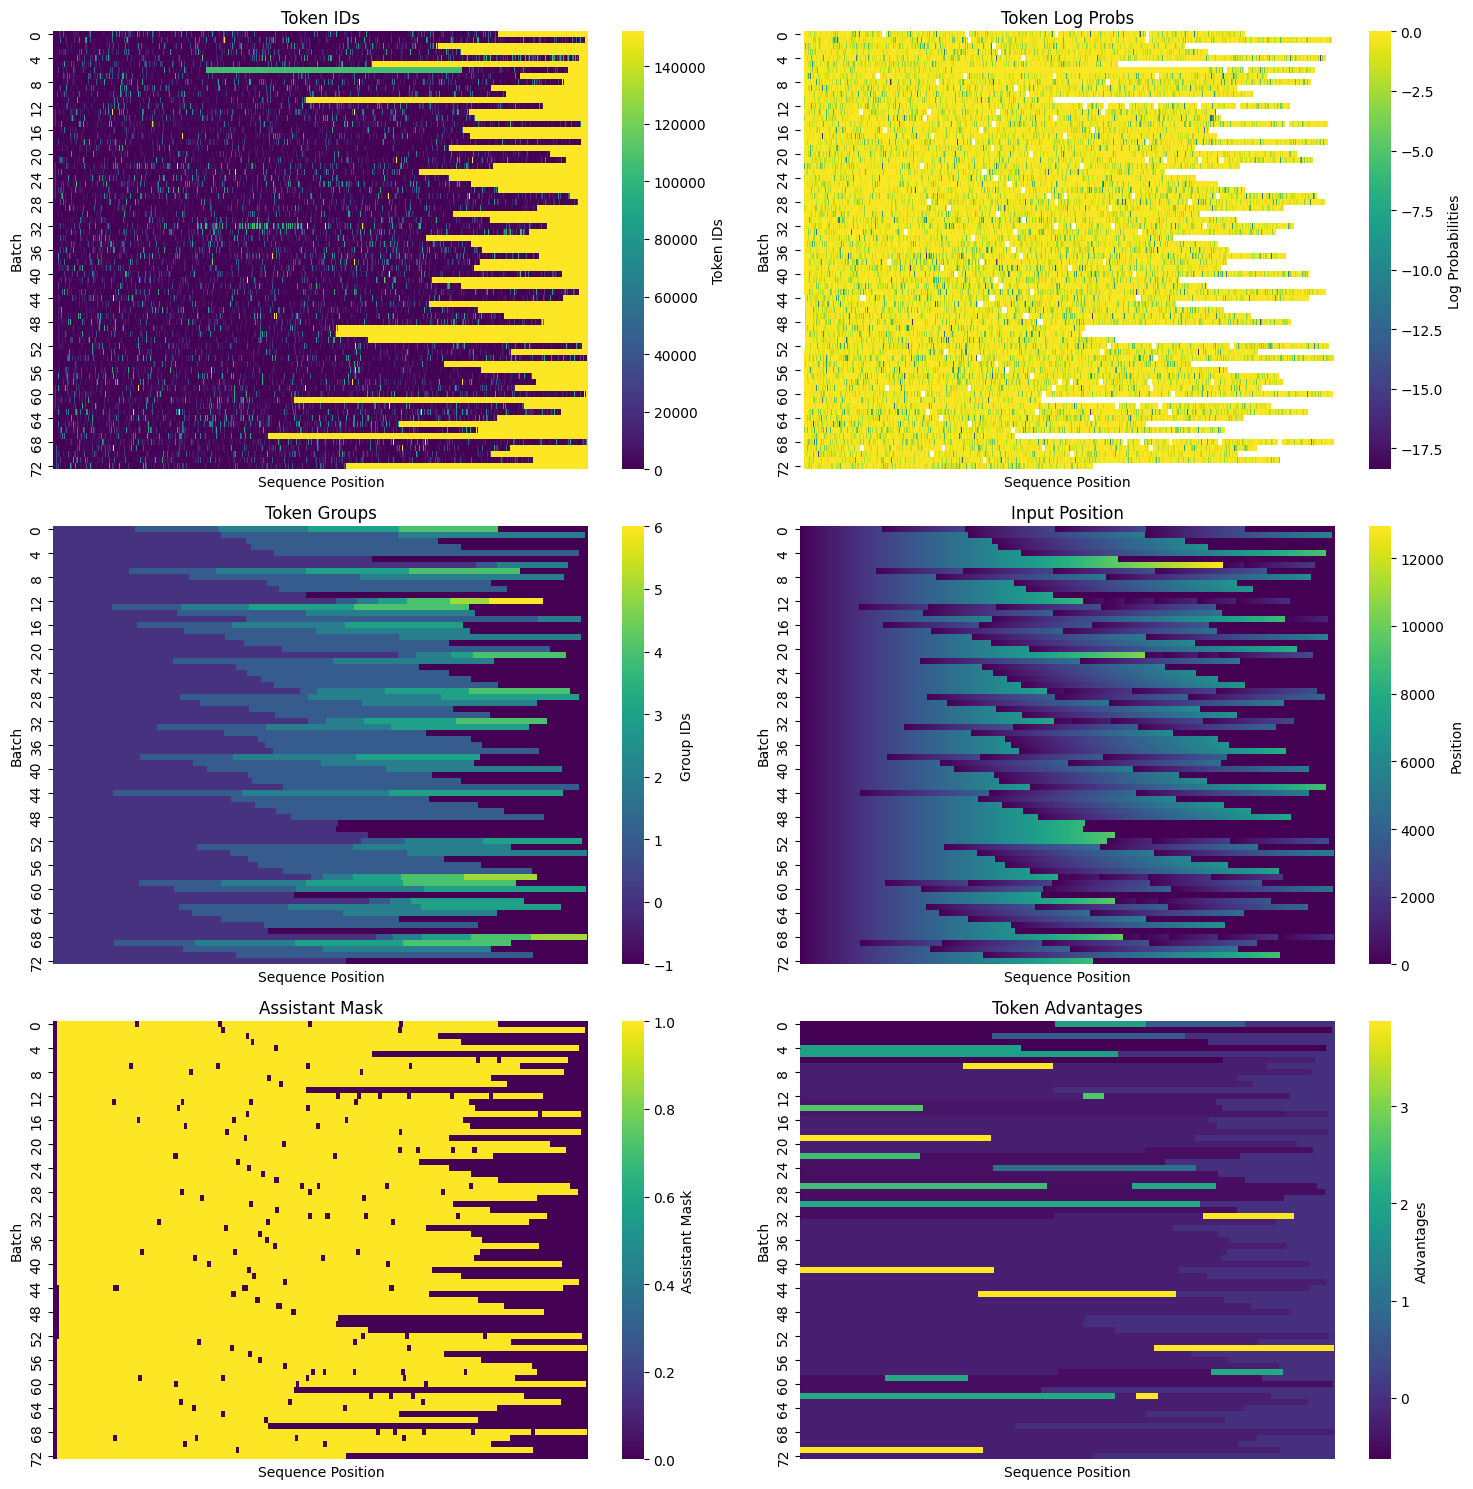

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740007789.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.36 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|36|Loss: -0.7545: 100%|██████████| 36/36 [14:06<00:00, 23.21s/it, entropy=2.33, kl_div=0.441, loss=-0.755, policy=-0.755]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.11 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-19 23:45:01 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 23:45:02 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 23:45:02 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.52s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.75s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.87s/it]



INFO 02-19 23:45:22 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-19 23:45:23 worker.py:267] Memory profiling takes 0.77 seconds
INFO 02-19 23:45:23 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-19 23:45:23 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-19 23:45:23 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-19 23:45:23 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-19 23:46:02 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.35 seconds
INFO 02-19 23:46:04 api_server.py:756] Using supplied chat template:
INFO 02-19 23:46:04 api_server.py:756] None
INFO 02-19 23:46:04 launcher.py:21] Available routes are:
INFO 02-19 23:46:04 launcher.py:29] Route: /

INFO:     Started server process [54595]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 23:46:07 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:44368 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

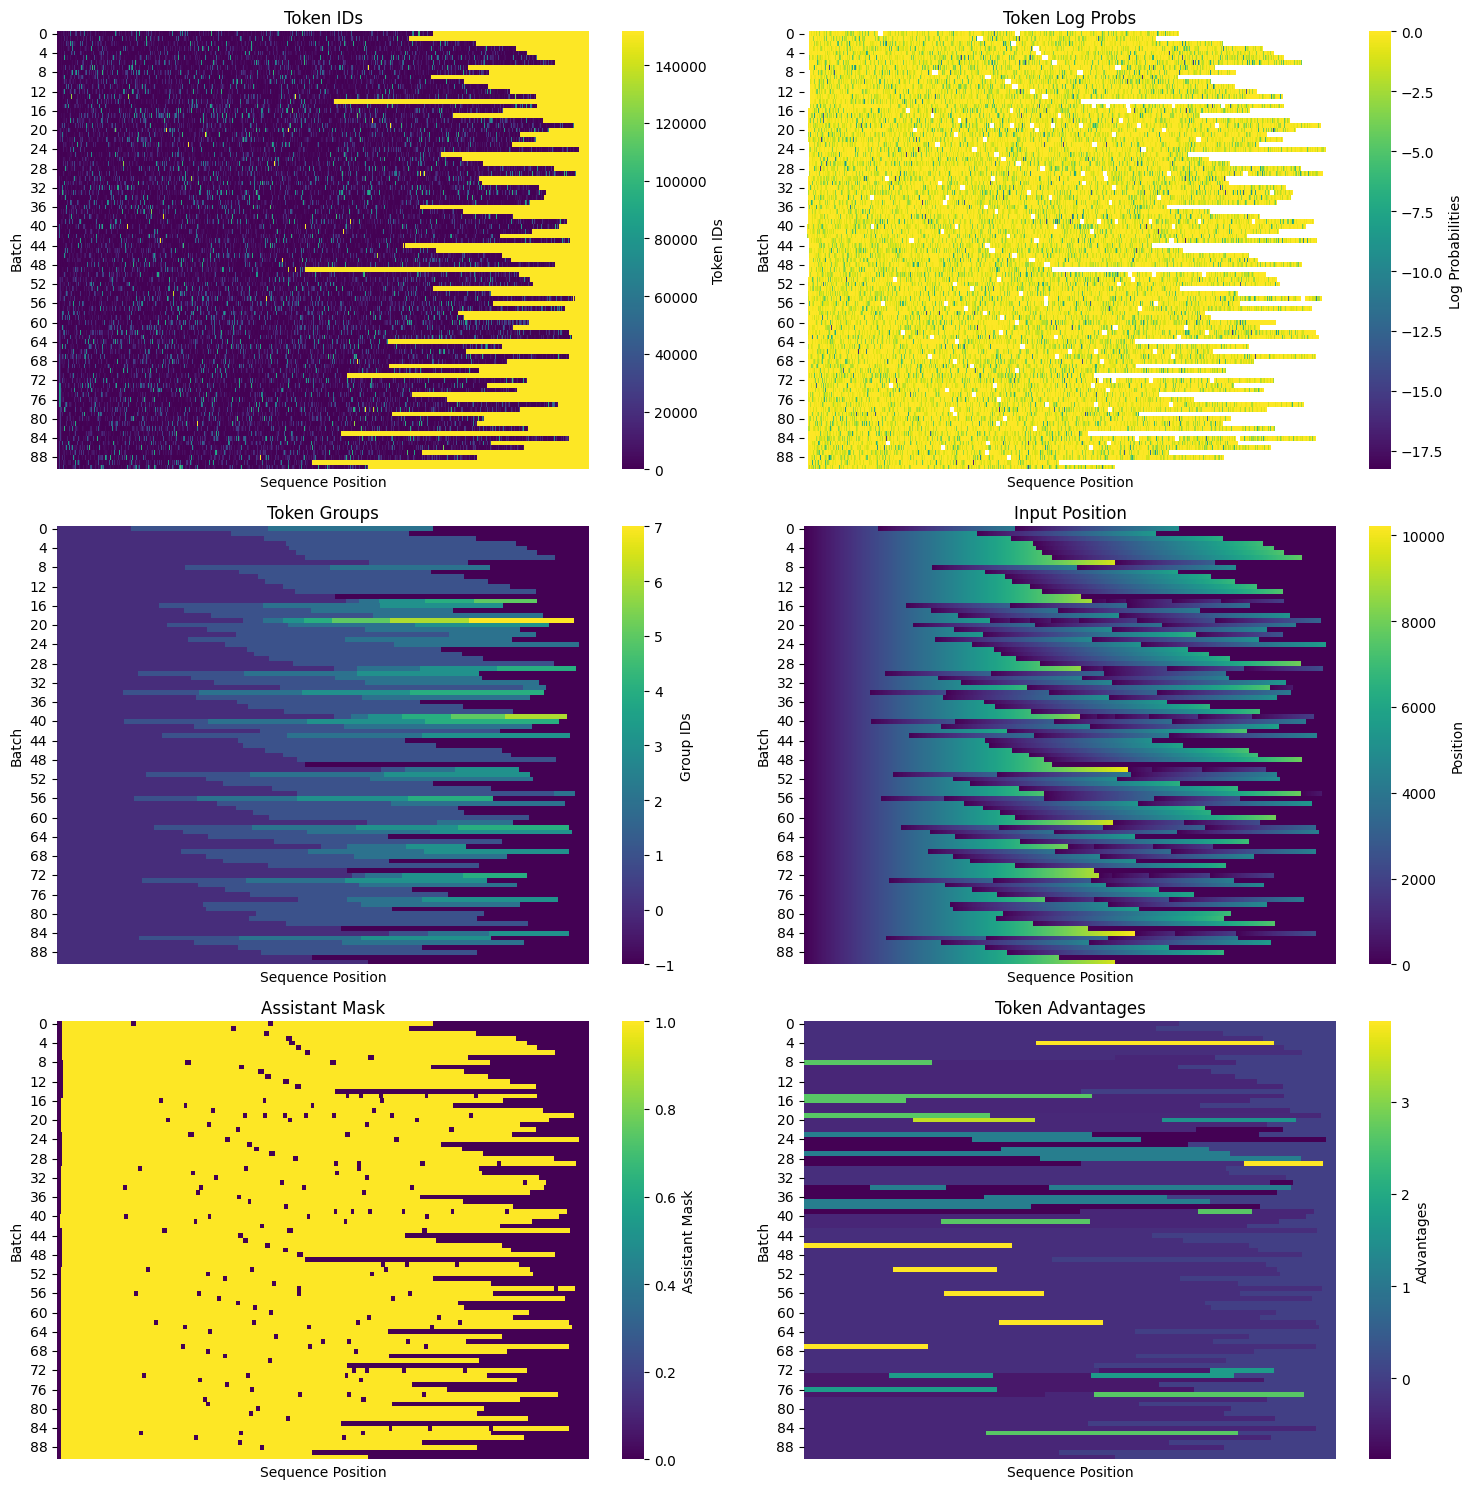

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740009316.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.52 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|45|Loss: 0.3023: 100%|██████████| 45/45 [17:37<00:00, 23.20s/it, entropy=2.69, kl_div=0.544, loss=0.302, policy=0.302]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.02 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved 

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-20 00:13:59 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 00:13:59 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 00:13:59 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.45s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.72s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.83s/it]



INFO 02-20 00:14:19 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-20 00:14:20 worker.py:267] Memory profiling takes 0.82 seconds
INFO 02-20 00:14:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 00:14:20 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-20 00:14:20 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-20 00:14:20 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-20 00:15:00 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.63 seconds
INFO 02-20 00:15:01 api_server.py:756] Using supplied chat template:
INFO 02-20 00:15:01 api_server.py:756] None
INFO 02-20 00:15:01 launcher.py:21] Available routes are:
INFO 02-20 00:15:01 launcher.py:29] Route: /

INFO:     Started server process [57068]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-20 00:15:07 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-20 00:15:07 metrics.py:455] Avg prompt throughput: 0.9 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-20 00:15:07 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:58870 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

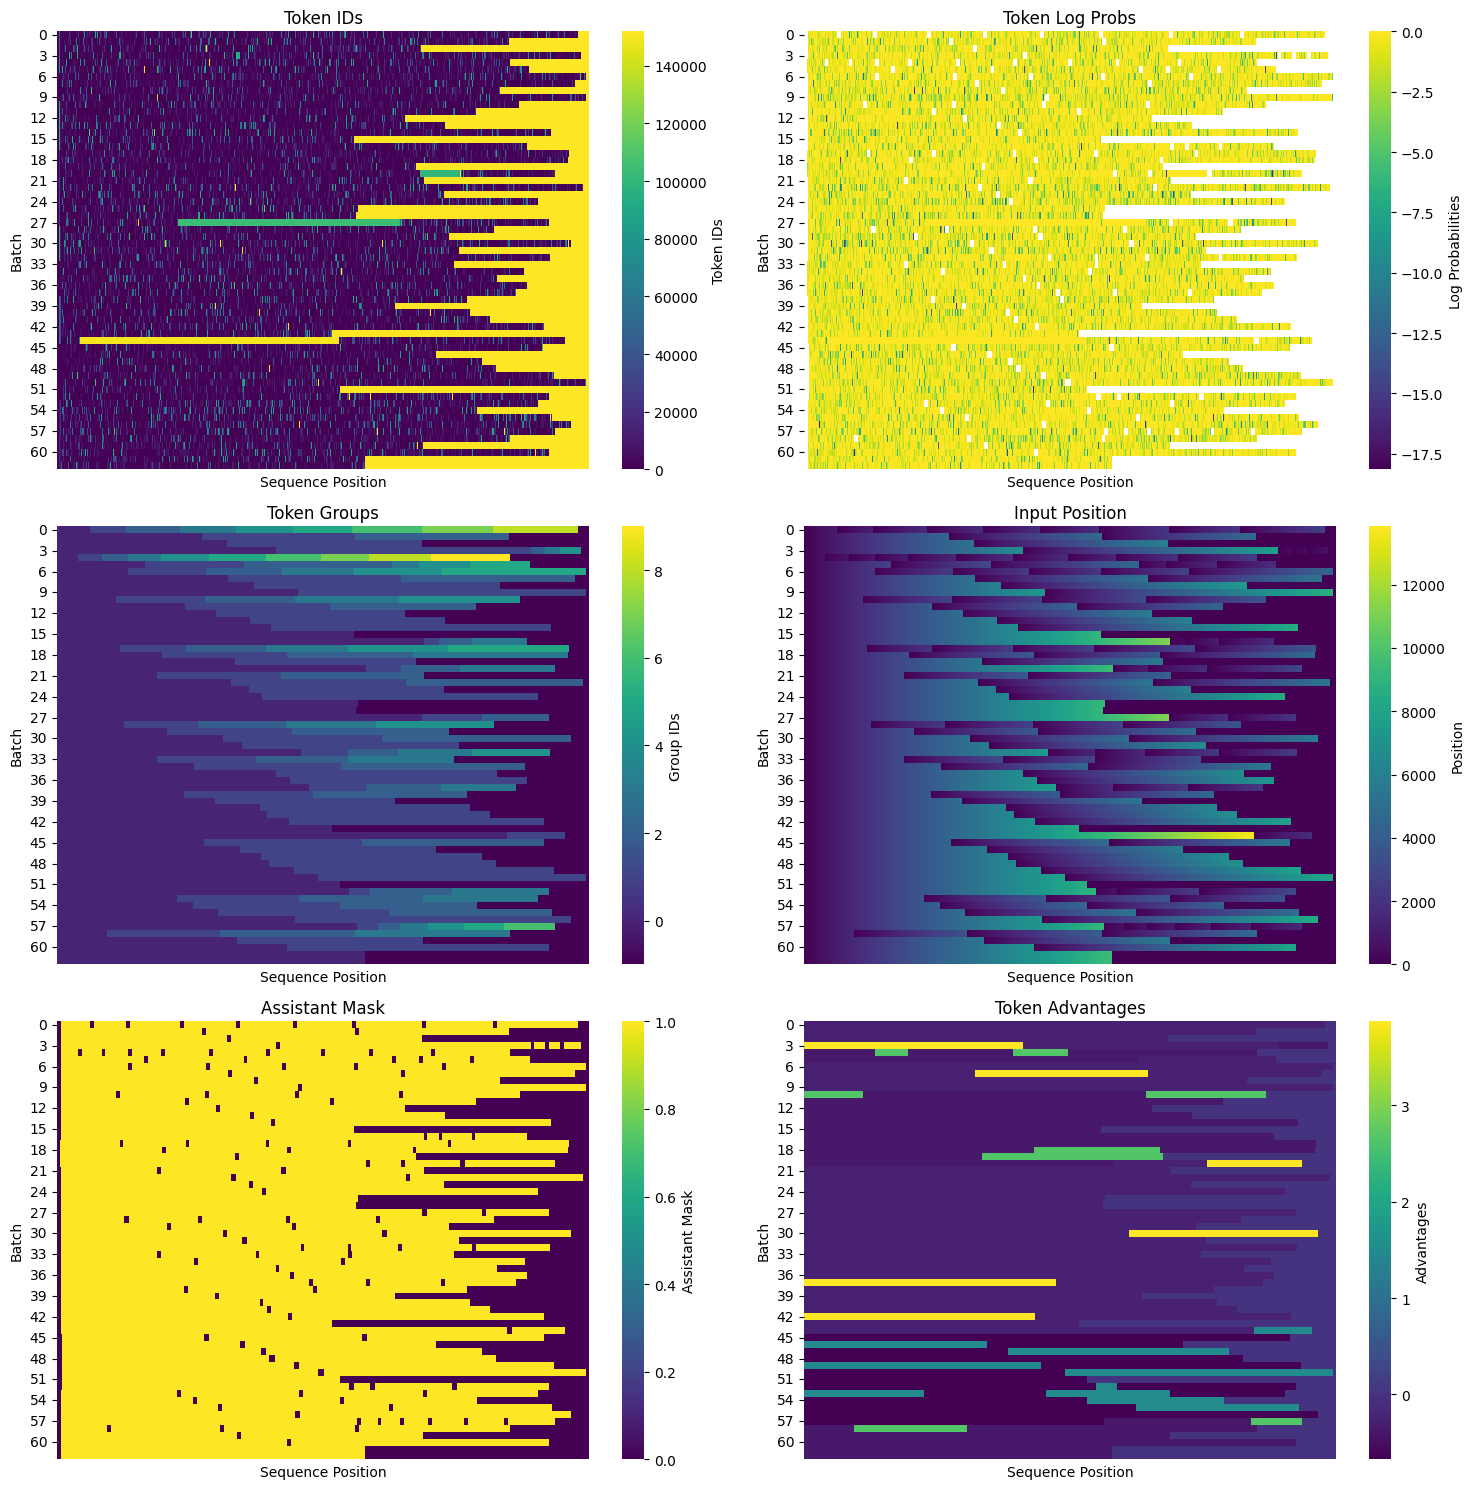

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740011118.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.56 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|31|Loss: 0.3122: 100%|██████████| 31/31 [12:10<00:00, 23.19s/it, entropy=2.62, kl_div=0.532, loss=0.312, policy=0.312]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.98 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB save

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-20 00:38:34 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 00:38:35 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 00:38:35 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.49s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.72s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.83s/it]



INFO 02-20 00:38:55 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-20 00:38:56 worker.py:267] Memory profiling takes 0.78 seconds
INFO 02-20 00:38:56 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 00:38:56 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-20 00:38:56 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-20 00:38:56 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-20 00:39:35 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.36 seconds
INFO 02-20 00:39:37 api_server.py:756] Using supplied chat template:
INFO 02-20 00:39:37 api_server.py:756] None
INFO 02-20 00:39:37 launcher.py:21] Available routes are:
INFO 02-20 00:39:37 launcher.py:29] Route: /

INFO:     Started server process [59068]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-20 00:39:37 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:50366 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

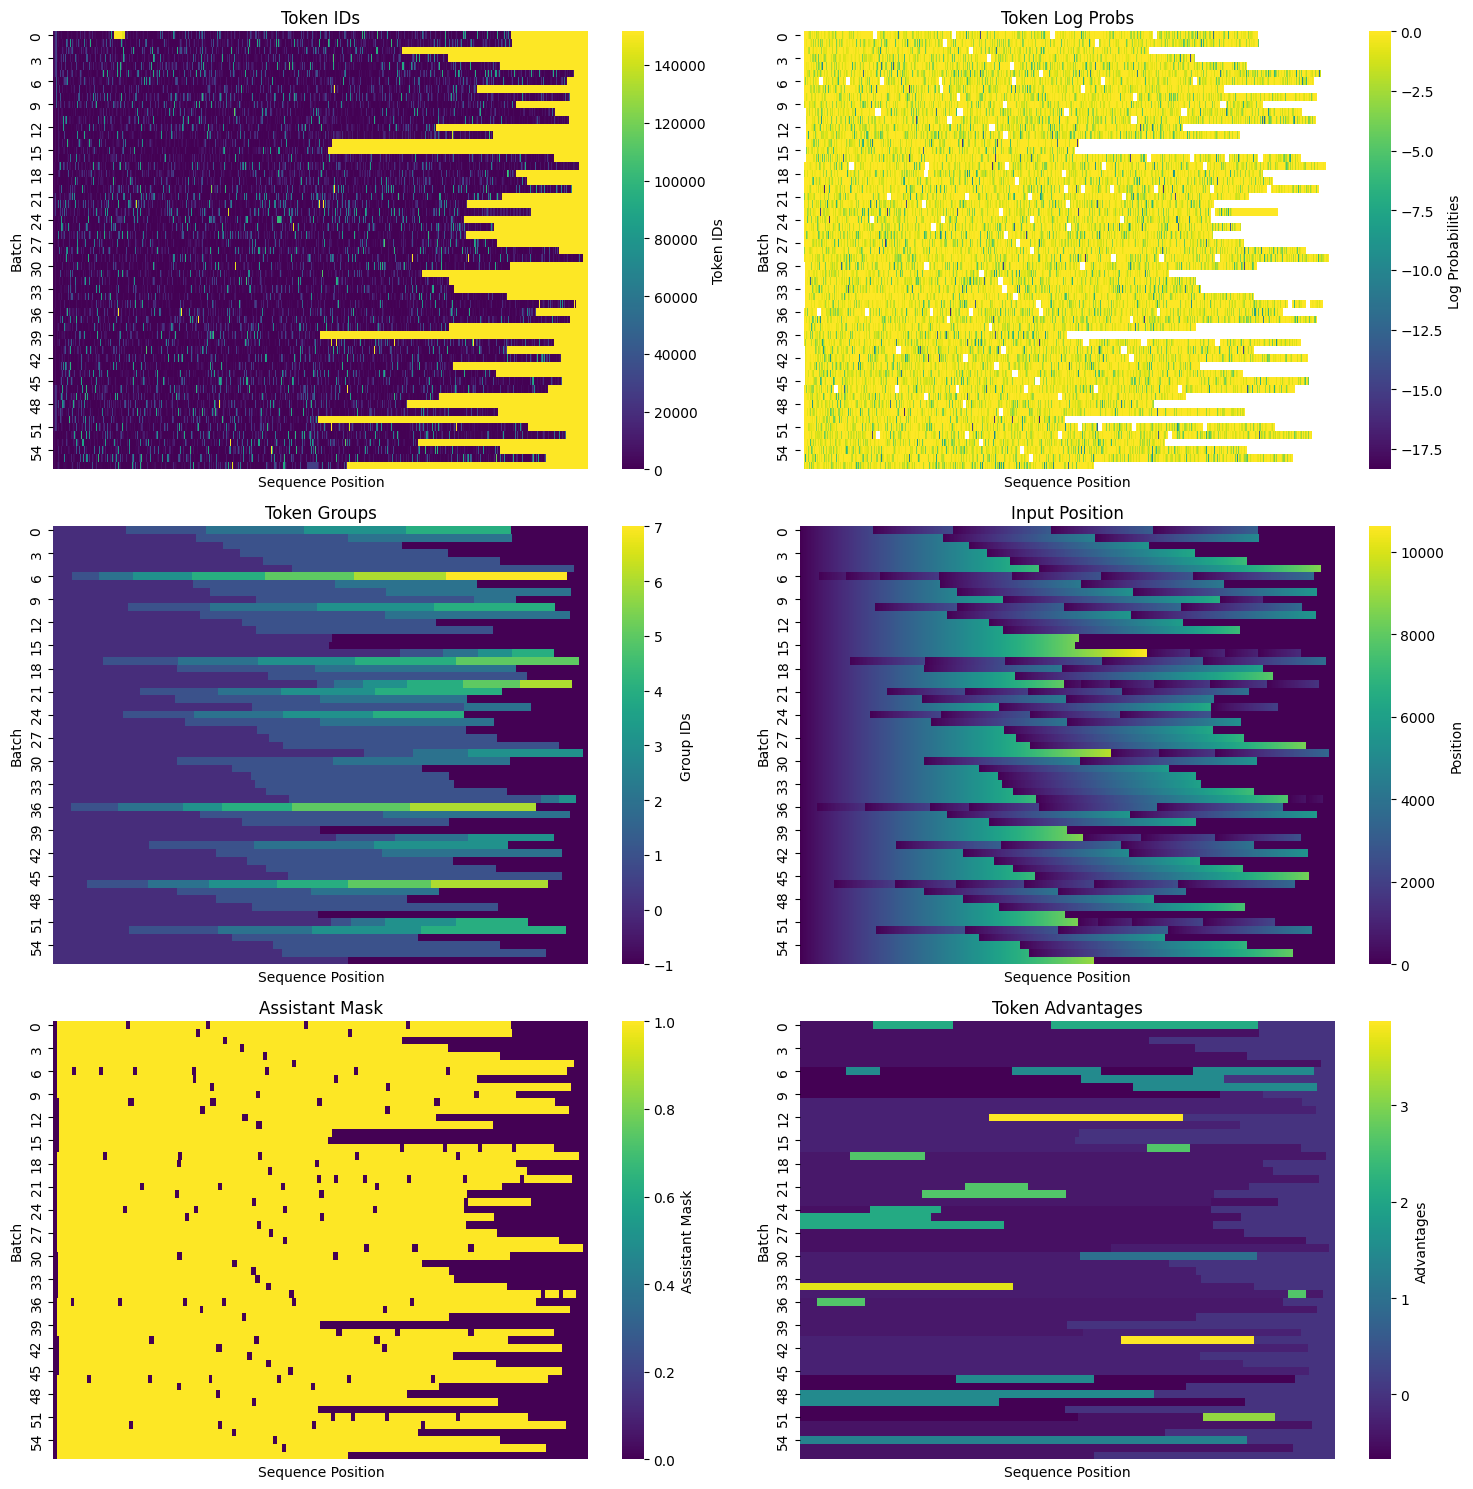

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740012525.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.44 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|28|Loss: -0.5497: 100%|██████████| 28/28 [11:00<00:00, 23.22s/it, entropy=2.58, kl_div=0.493, loss=-0.55, policy=-0.55]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.03 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved to

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-20 01:00:51 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 01:00:52 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 01:00:52 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.46s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-20 01:01:12 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-20 01:01:13 worker.py:267] Memory profiling takes 0.92 seconds
INFO 02-20 01:01:13 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 01:01:13 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-20 01:01:13 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-20 01:01:13 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-20 01:01:53 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.98 seconds
INFO 02-20 01:01:54 api_server.py:756] Using supplied chat template:
INFO 02-20 01:01:54 api_server.py:756] None
INFO 02-20 01:01:54 launcher.py:21] Available routes are:
INFO 02-20 01:01:54 launcher.py:29] Route: /

INFO:     Started server process [60747]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-20 01:02:01 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-20 01:02:01 metrics.py:455] Avg prompt throughput: 0.8 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-20 01:02:01 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:50866 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

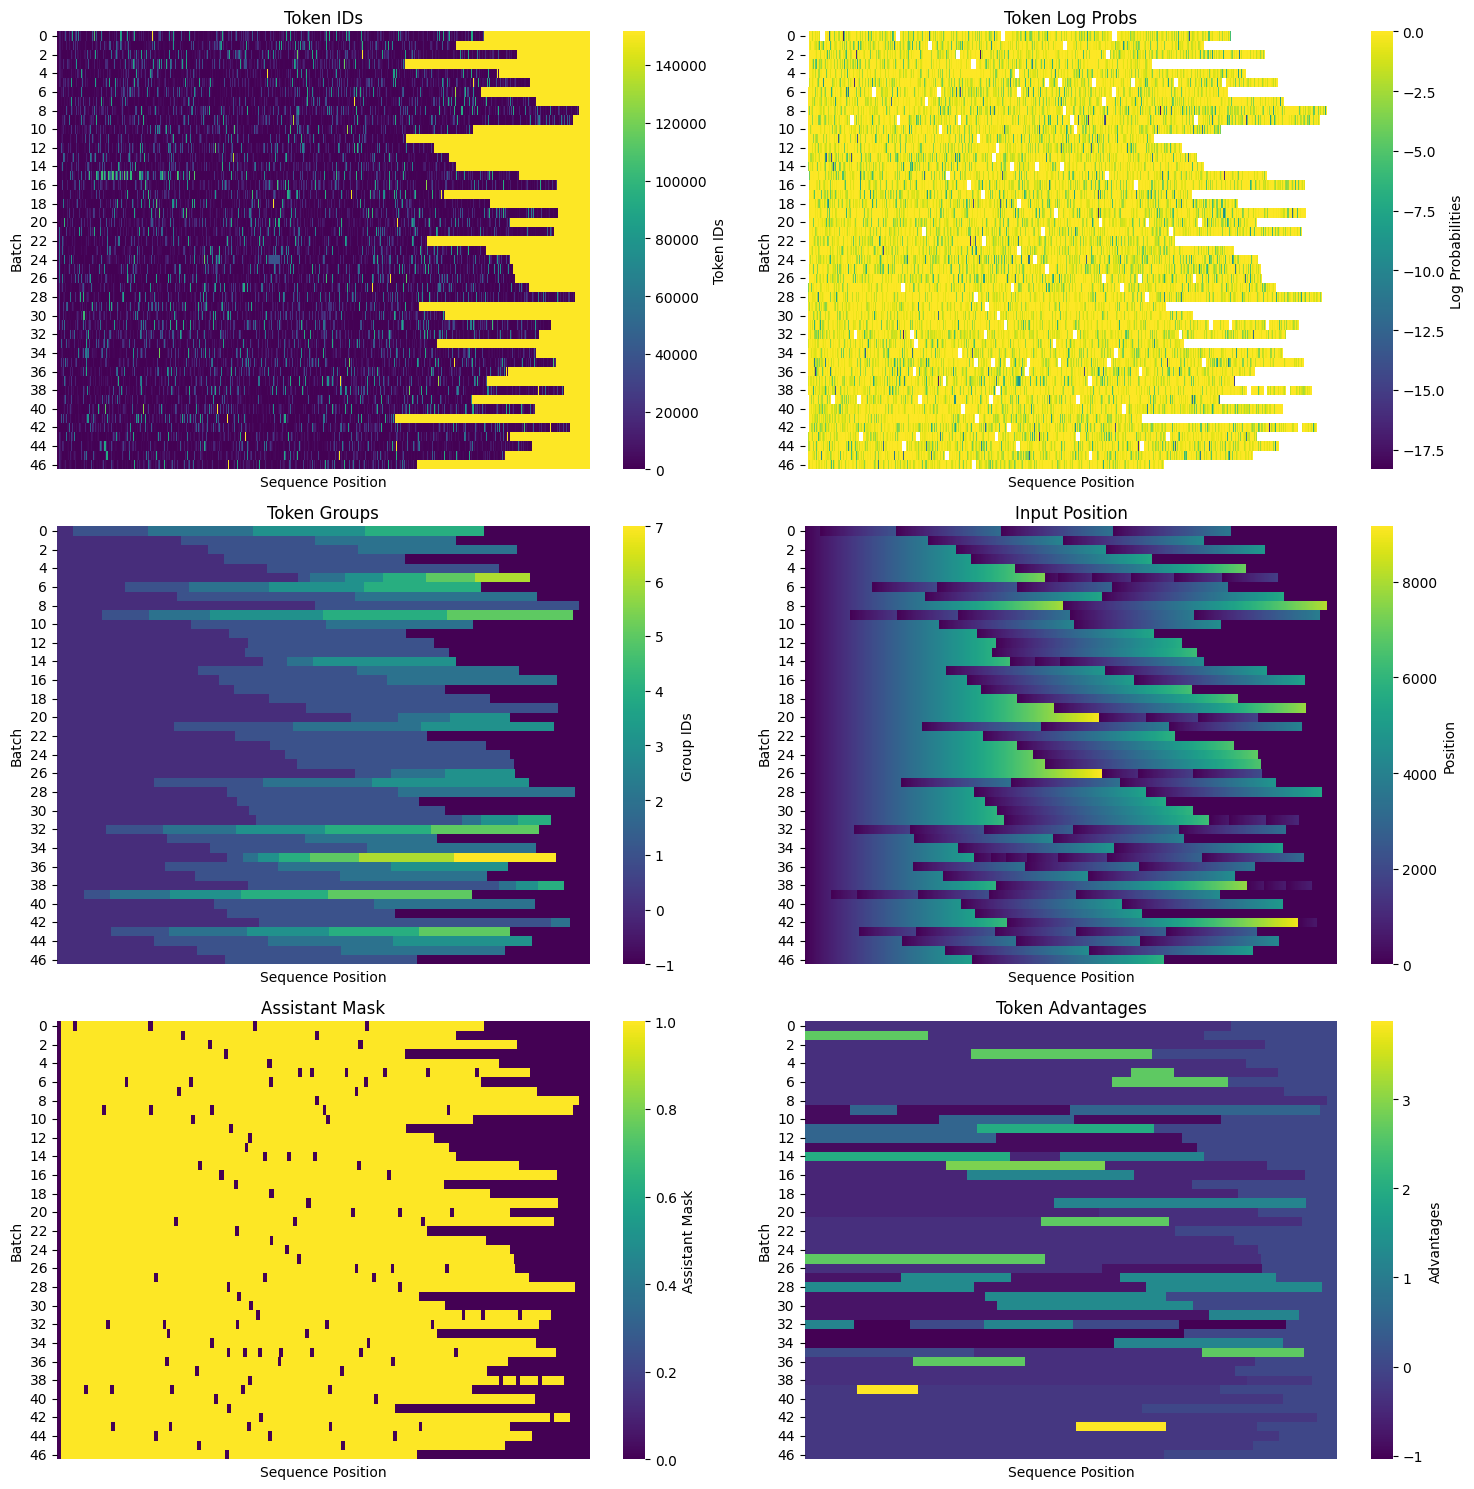

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740013855.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.50 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|23|Loss: 0.2170: 100%|██████████| 23/23 [09:06<00:00, 23.24s/it, entropy=2.22, kl_div=0.534, loss=0.217, policy=0.217]       INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.95 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB sa

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-20 01:21:06 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 01:21:07 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 01:21:07 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.47s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.82s/it]



INFO 02-20 01:21:27 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-20 01:21:27 worker.py:267] Memory profiling takes 0.75 seconds
INFO 02-20 01:21:27 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 01:21:27 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-20 01:21:28 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-20 01:21:28 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-20 01:22:07 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.64 seconds
INFO 02-20 01:22:09 api_server.py:756] Using supplied chat template:
INFO 02-20 01:22:09 api_server.py:756] None
INFO 02-20 01:22:09 launcher.py:21] Available routes are:
INFO 02-20 01:22:09 launcher.py:29] Route: /

INFO:     Started server process [62419]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-20 01:22:09 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:52012 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

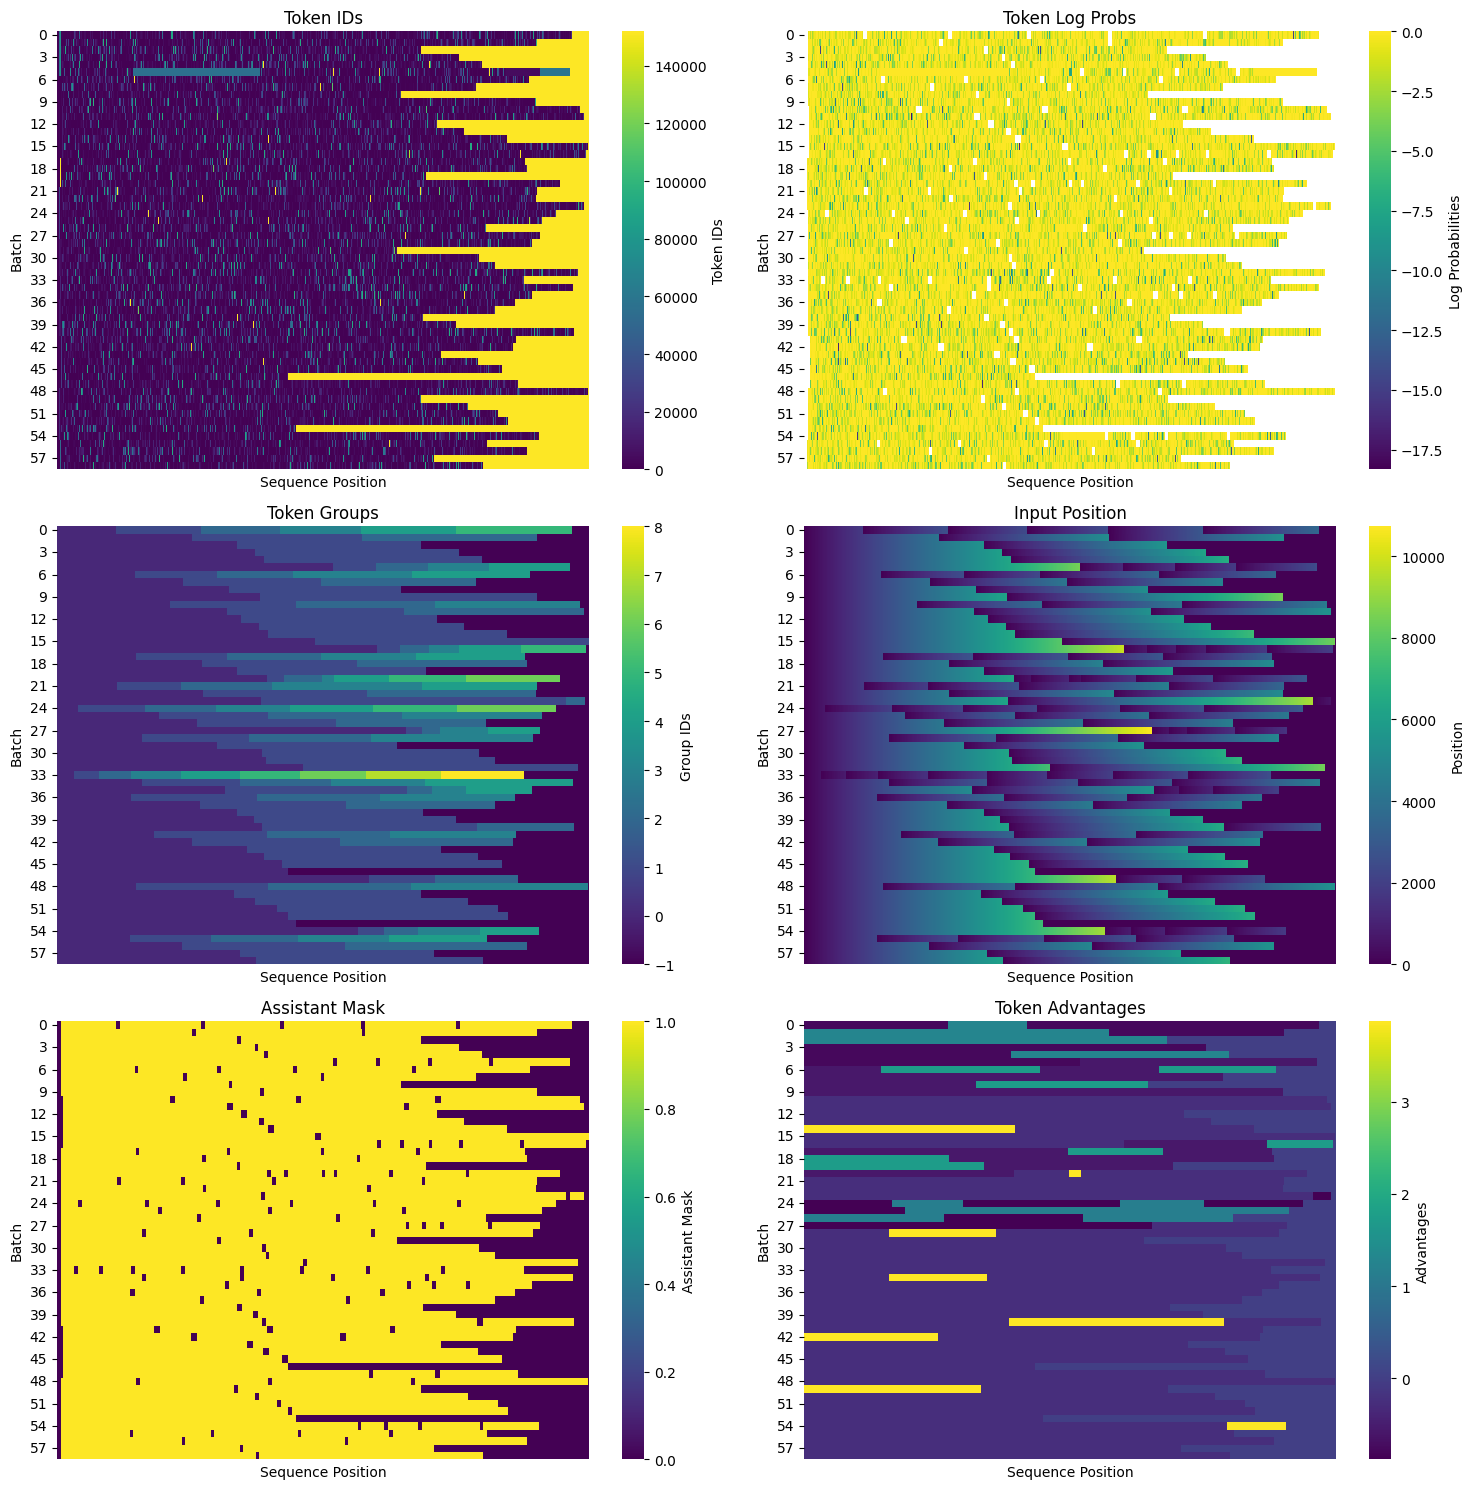

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740015076.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.82 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|29|Loss: 0.2270: 100%|██████████| 29/29 [11:24<00:00, 23.20s/it, entropy=2.29, kl_div=0.498, loss=0.227, policy=0.227]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.91 secs
INFO:torchtune.utils._logging:Model checkpoint of size 8.61 GB saved t

Saved iteration #1 model files to ./models/010/0001
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/010/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/010/0001 --port=8000 --api-key=default
INFO 02-20 01:43:46 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 01:43:47 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 01:43:47 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/010/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:05<00:05,  5.47s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.71s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:09<00:00,  4.83s/it]



INFO 02-20 01:44:07 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-20 01:44:07 worker.py:267] Memory profiling takes 0.76 seconds
INFO 02-20 01:44:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-20 01:44:07 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.83GiB.
INFO 02-20 01:44:08 executor_base.py:110] # CUDA blocks: 33840, # CPU blocks: 46811
INFO 02-20 01:44:08 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.09x
INFO 02-20 01:44:47 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 40.26 seconds
INFO 02-20 01:44:48 api_server.py:756] Using supplied chat template:
INFO 02-20 01:44:48 api_server.py:756] None
INFO 02-20 01:44:48 launcher.py:21] Available routes are:
INFO 02-20 01:44:48 launcher.py:29] Route: /

INFO:     Started server process [63910]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-20 01:44:51 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:35880 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7757440ca840>
Traceback (most recent call last):
  File "/home/gcpuser/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/gcpuser/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

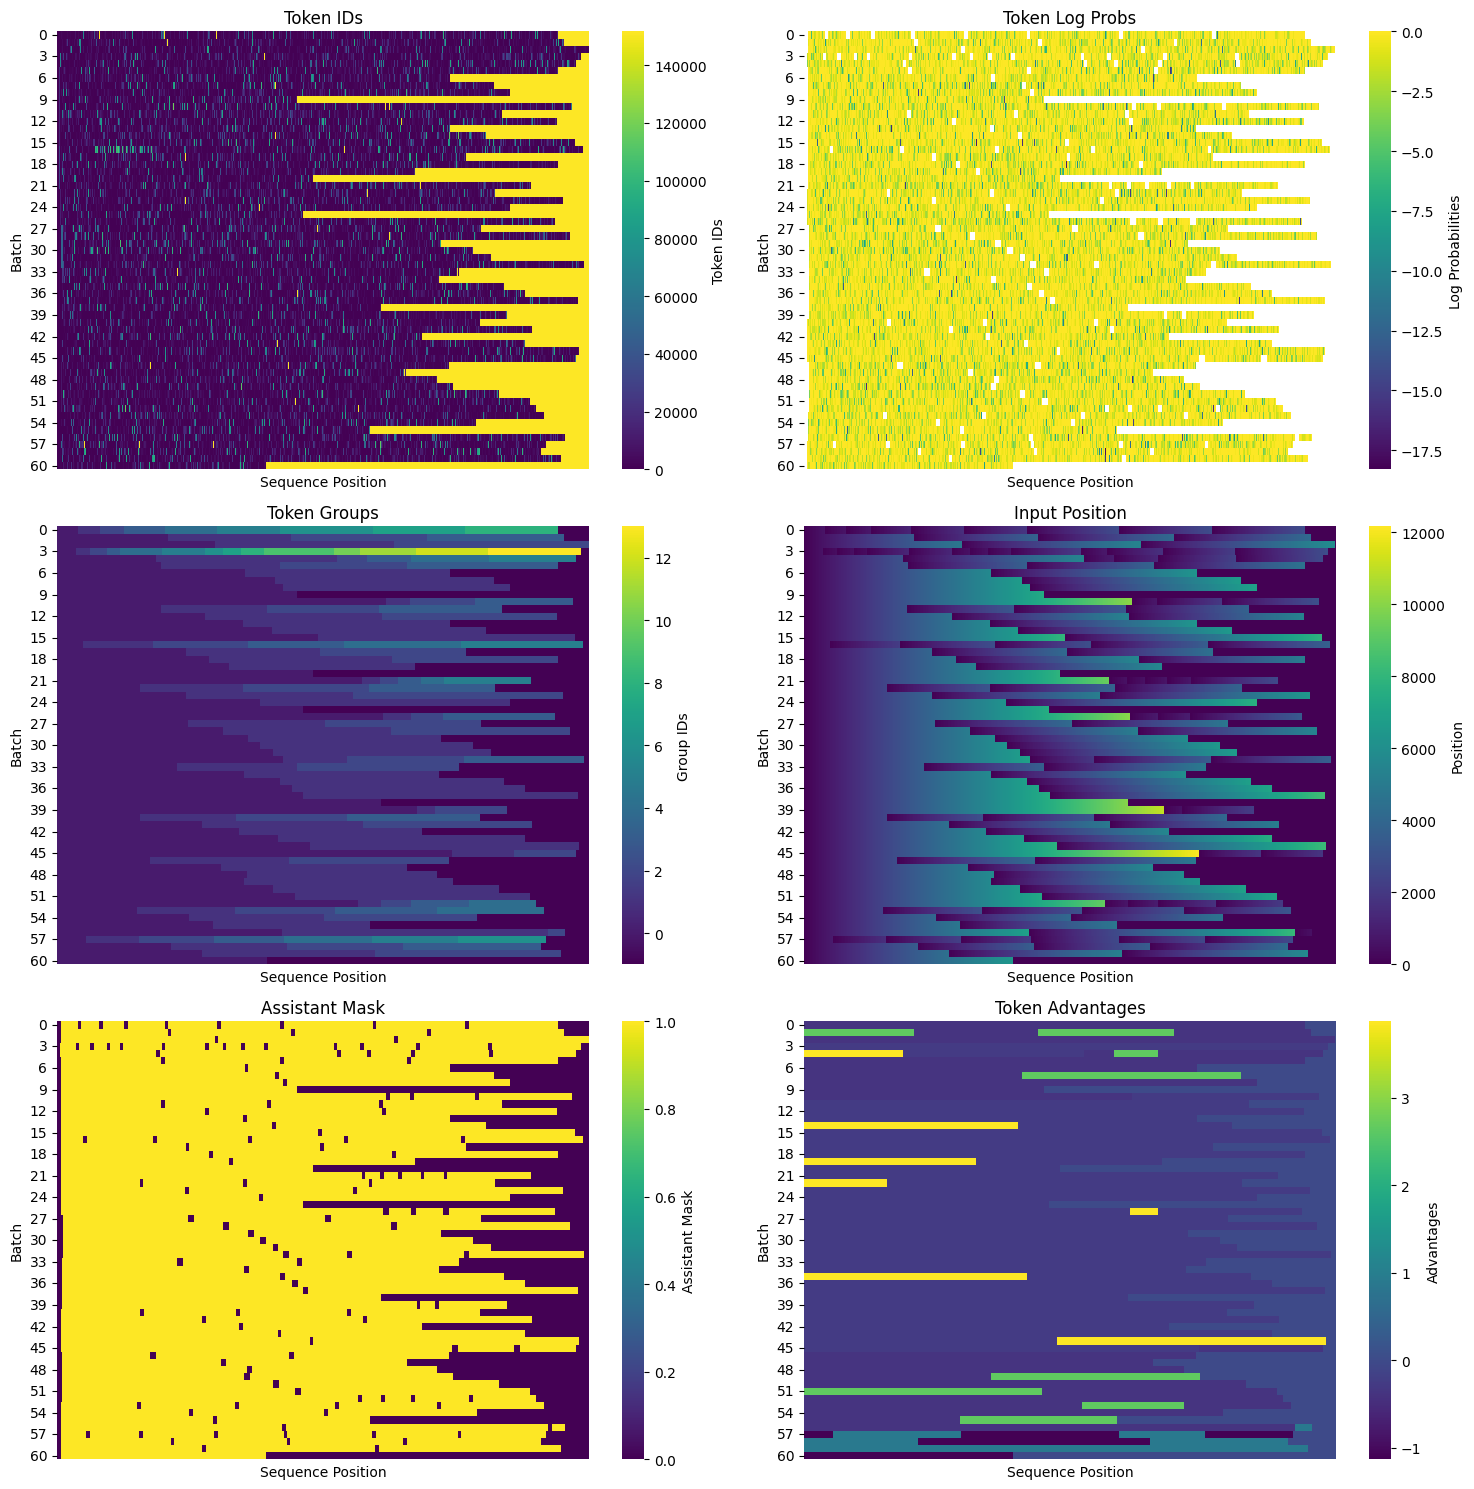

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/010/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  - /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/010
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/010/tensors
  num_se

Writing logs to models/010/logs/log_1740016425.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.24 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|2|Loss: 0.3035:   7%|▋         | 2/30 [00:57<13:00, 27.88s/it, entropy=1.88, kl_div=0.483, loss=0.303, policy=0.303]   

In [ ]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = float("inf")
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0

expected_tokens = 3500  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 1e-5
model = models.qwen_7b()
wandb.config["model"] = model_name = model.base_model
num_iterations = 100
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 16
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 32
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity = 2

for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=512,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=512,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=120 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(vllm.max_concurrent_tokens // expected_tokens)
    offset = i * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": val_stats.completion_tokens / val_stats.usages,
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = round(wandb_data["tokens"])
    vllm.process.terminate()
    kill_vllm_workers()
    packed_tensors = packed_tensors_from_tokenized_results(
        [
            result
            for results in train_results
            for result in results
            if result.advantage != 0
        ],
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(model.tune_optimizer, lr=lr)
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
            ),
            optimizer=optimizer_config,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()